<a href="https://colab.research.google.com/github/Iykechuks11/Adversarial-neural-cryptography-with-authenticated-encryption/blob/master/adversarial_neural_crypto_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

In [ ]:
import torch
import torch.nn as nn

torch.__version__

'2.3.0+cu121'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DEVICE = torch.device(
    'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
)

DEVICE

device(type='cpu')

In [ ]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Data

In [ ]:
# Generic random batch function
def random_batch(X_train, y_train, batch_size):
    index_set = np.random.randint(0, X_train.shape[0], batch_size)
    X_batch = X_train[index_set]
    y_batch = y_train[index_set]
    return X_batch, y_batch

In [ ]:
from random import seed
seed(0)
m_bits = 8
k_bits = 8
c_bits = 8
batch_size = 4

m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
m_batch

array([[1, 0, 0, 1, 0, 1, 0, 1],
       [1, 1, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 1, 1, 1, 0, 0]])

In [ ]:
k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
k_batch

array([[0, 1, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0]])

# Training loop

In [ ]:
def train_single_epoch(alice, bob, eve, abeoptim, eveoptim, abecycles, evecycles, batch_size=32, device=DEVICE):
    n_iterations = m_train // batch_size
    iteration = 0
    abeloss_sum = 0
    bobloss_sum = 0
    eveloss_sum = 0
    while iteration < n_iterations:
        ###########################################################################################################
        # Train AB-E (updates Alice and Bob paramters, but not Eve)
        #
        alice.train()
        bob.train()
        eve.train()
        for param in alice.parameters():
            param.requires_grad = True
        for param in bob.parameters():
            param.requires_grad = True
        for param in eve.parameters():
            param.requires_grad = False

        for _ in range(abecycles):
            m_batch = torch.Tensor(np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)).to(DEVICE)
            k_batch = torch.Tensor(np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)).to(DEVICE)
            #print(m_batch.shape, k_batch.shape)

            # Forward pass
            ciphertext = alice((m_batch, k_batch))  # alice gets (message, key)
            bobout = bob((ciphertext, k_batch))  # bob gets (ciphertext, key)
            eveout = eve(ciphertext)  # eve doesn't see the key, only the ciphertext

            # Calculate loss
            bobloss = torch.mean(  torch.sum(torch.abs(m_batch - bobout), axis=-1)  )  # Bob's ability to decode
            bobloss_sum += bobloss.cpu().detach().numpy() / abecycles

            # Loss for Alice-Bob communication depends on Bob's reconstruction, but also
            # on Eve's ability to decode the message. Eve should do no better than random guesing,
            # so on average she will guess half the bits right (hence the m_bits/2)
            eveloss = torch.mean(  torch.sum(torch.abs(m_batch - eveout), axis=-1)  )  # Eve's ability to guess
            abeloss = bobloss + torch.square(m_bits/2 - eveloss) / (  (m_bits//2)**2  )
            abeloss_sum += abeloss.cpu().detach().numpy() / abecycles

            # Optimizer zero grad
            abeoptim.zero_grad()

            # Loss backward
            abeloss.backward()

            # Optimizer step
            abeoptim.step()

        ###########################################################################################################
        # Train Eve (updates Eve parameters, but not Alice/Bob)
        #
        for param in alice.parameters():
            param.requires_grad = False
        for param in bob.parameters():  # technically not required, since bob is not part of aemodel
            param.requires_grad = False
        for param in eve.parameters():
            param.requires_grad = True

        for _ in range(evecycles):
            m_batch = torch.Tensor(np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)).to(DEVICE)
            k_batch = torch.Tensor(np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)).to(DEVICE)

            # Forward pass
            ciphertext = alice((m_batch, k_batch))  # alice gets (message, key)
            eveout = eve(ciphertext)  # eve doesn't see the key, only the ciphertext

            # Calculate loss
            eveloss = torch.mean(  torch.sum(torch.abs(m_batch - eveout), axis=-1)  )  # Eve's ability to guess
            eveloss_sum += eveloss.cpu().detach().numpy() / evecycles

            # Optimizer zero grad
            eveoptim.zero_grad()

            # Loss backward
            eveloss.backward()

            # Optimizer step
            eveoptim.step()

        iteration += 1

    # Evaluate code goes here (if splitting message space into train/validation/test)
    # ...
    alice.eval()
    bob.eval()
    eve.eval()
    with torch.inference_mode():
        pass

    return abeloss_sum/n_iterations, bobloss_sum/n_iterations, eveloss_sum/n_iterations

In [ ]:
def train_single_epoch_leaky_v0(alice, bob, eve, abeoptim, eveoptim, abecycles, evecycles, n_leak, batch_size=32, device=DEVICE):
    n_iterations = m_train // batch_size
    iteration = 0
    abeloss_sum = 0
    bobloss_sum = 0
    eveloss_sum = 0
    while iteration < n_iterations:
        ###########################################################################################################
        # Train AB-E (updates Alice and Bob paramters, but not Eve)
        #
        alice.train()
        bob.train()
        eve.train()
        for param in alice.parameters():
            param.requires_grad = True
        for param in bob.parameters():
            param.requires_grad = True
        for param in eve.parameters():
            param.requires_grad = False

        for _ in range(abecycles):
            m_batch = torch.Tensor(np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)).to(DEVICE)
            k_batch = torch.Tensor(np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)).to(DEVICE)

            # Create a separate copy of the key and zero out part of it
            k0_batch = torch.clone(k_batch).to(DEVICE)
            k0_batch[:,n_leak:] = 0.0

            # Forward pass
            ciphertext = alice((m_batch, k_batch))  # alice gets (message, key)
            bobout = bob((ciphertext, k_batch))  # bob gets (ciphertext, key)
            eveout = eve((ciphertext, k0_batch))  # eve sees part the key, with some of it being zeroed out

            # Calculate loss
            bobloss = torch.mean(  torch.sum(torch.abs(m_batch - bobout), axis=-1)  )  # Bob's ability to decode
            bobloss_sum += bobloss.cpu().detach().numpy() / abecycles

            # Loss for Alice-Bob communication depends on Bob's reconstruction, but also
            # on Eve's ability to decode the message. Eve should do no better than random guesing,
            # so on average she will guess half the bits right (hence the m_bits/2)
            eveloss = torch.mean(  torch.sum(torch.abs(m_batch - eveout), axis=-1)  )  # Eve's ability to guess
            abeloss = bobloss + torch.square(m_bits/2 - eveloss) / (  (m_bits//2)**2  )
            abeloss_sum += abeloss.cpu().detach().numpy() / abecycles

            # Optimizer zero grad
            abeoptim.zero_grad()

            # Loss backward
            abeloss.backward()

            # Optimizer step
            abeoptim.step()

        ###########################################################################################################
        # Train Eve (updates Eve parameters, but not Alice/Bob)
        #
        for param in alice.parameters():
            param.requires_grad = False
        for param in bob.parameters():  # technically not required, since bob is not part of aemodel
            param.requires_grad = False
        for param in eve.parameters():
            param.requires_grad = True

        for _ in range(evecycles):
            m_batch = torch.Tensor(np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)).to(DEVICE)
            k_batch = torch.Tensor(np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)).to(DEVICE)

            # Create a separate copy of the key and zero out part of it
            k0_batch = torch.clone(k_batch).to(DEVICE)
            k0_batch[:,n_leak:] = 0.0

            # Forward pass
            ciphertext = alice((m_batch, k_batch))  # alice gets (message, key)
            eveout = eve((ciphertext, k0_batch))  # eve sees part the key, with some of it being zeroed out

            # Calculate loss
            eveloss = torch.mean(  torch.sum(torch.abs(m_batch - eveout), axis=-1)  )  # Eve's ability to guess
            eveloss_sum += eveloss.cpu().detach().numpy() / evecycles

            # Optimizer zero grad
            eveoptim.zero_grad()

            # Loss backward
            eveloss.backward()

            # Optimizer step
            eveoptim.step()

        iteration += 1

    # Evaluate code goes here (if splitting message space into train/validation/test)
    # ...
    alice.eval()
    bob.eval()
    eve.eval()
    with torch.inference_mode():
        pass

    return abeloss_sum/n_iterations, bobloss_sum/n_iterations, eveloss_sum/n_iterations

# Model 0 (base)

This model was build according to the specifications from Google's paper *Learning to protect communications with adversarial neural cryptography*.

In [ ]:
# Set up the crypto parameters: message, key, and ciphertext bit lengths
m_bits = 8
k_bits = 8
c_bits = 8
pad = 'same'

## EncoderModel (Alice)

In [ ]:
class EncoderModel(nn.Module):
    def __init__(self, m_bits, k_bits, pad='same'):
        super().__init__()
        self.m_bits = m_bits
        self.k_bits = k_bits

        # Define the initial layers
        self.dense0 = nn.Linear(in_features=m_bits+k_bits, out_features=m_bits+k_bits)
        self.activ0 = nn.Tanh()

        # Define the convolutional operations
        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=4, stride=1, padding=pad),
            nn.Tanh(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride=2),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=pad),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride=1, padding=pad),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        m, k = inputs  # message, key
        #print(m.shape, k.shape)

        # concatenate the inputs, then apply dense
        x = torch.cat([m, k], dim=-1)
        #print(x.shape)
        x = self.activ0(self.dense0(x))

        # reshape to add a "channels" dimension, apply convolutions, then flatten again
        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.squeeze(x, dim=1)
        return x

In [ ]:
alice = EncoderModel(m_bits=m_bits, k_bits=k_bits, pad=pad)

In [ ]:
m = torch.Tensor(np.zeros(m_bits)).unsqueeze(dim=0)
k = torch.Tensor(np.ones(k_bits)).unsqueeze(dim=0)
print(m.shape, k.shape)
print(m)
print(k)

alice.eval()

with torch.no_grad():
    c_out = alice((m, k))

print(c_out.shape)
c_out

torch.Size([1, 16]) torch.Size([1, 16])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
torch.Size([1, 16])


tensor([[0.4105, 0.4133, 0.4110, 0.4144, 0.4104, 0.4129, 0.4090, 0.4148, 0.4088,
         0.4162, 0.4122, 0.4112, 0.4141, 0.4108, 0.4152, 0.4110]])

## DecoderModel (Bob)

In [ ]:
class DecoderModel(nn.Module):
    def __init__(self, c_bits, k_bits, pad='same'):
        super().__init__()
        self.c_bits = c_bits
        self.k_bits = k_bits

        # Define the initial layers
        self.dense0 = nn.Linear(in_features=c_bits+k_bits, out_features=c_bits+k_bits)
        self.activ0 = nn.Tanh()

        # Define the convolutional operations
        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=4, stride=1, padding=pad),
            nn.Tanh(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride=2),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=pad),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride=1, padding=pad),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        c, k = inputs  # ciphertext, key
        #print(c.shape, k.shape)

        # concatenate the inputs, then apply dense
        x = torch.cat([c, k], dim=-1)
        x = self.activ0(self.dense0(x))

        # reshape to add a "channels" dimesion, apply convolutions, then flatten again
        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.squeeze(x, dim=1)
        return x

In [ ]:
bob = DecoderModel(c_bits=c_bits, k_bits=k_bits, pad=pad)

In [ ]:
c = c_out  # bob's input is the ciphertext (alice's output)
k = k # same key as alice

bob.eval()

with torch.no_grad():
    m_out = bob((c, k))

print(m_out.shape)
m_out

torch.Size([1, 8])


tensor([[0.4736, 0.4496, 0.4704, 0.4610, 0.4587, 0.4600, 0.4560, 0.4703]])

## AdversaryModel (Eve)

In [ ]:
class AdversaryModel(nn.Module):
    def __init__(self, c_bits, k_bits, pad='same'):
        super().__init__()
        self.c_bits = c_bits
        self.k_bits = k_bits

        # Define the initial layers
        self.dense0 = nn.Linear(in_features=c_bits, out_features=c_bits+k_bits)  # only sees the ciphertext
        self.activ0 = nn.Tanh()
        self.dense1 = nn.Linear(in_features=c_bits+k_bits, out_features=c_bits+k_bits)
        self.activ1 = nn.Tanh()

        # Define the convolutional operations
        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=4, stride=1, padding=pad),
            nn.Tanh(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride=2),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=pad),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride=1, padding=pad),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        c = inputs  # ciphertext only

        # apply dense layers to the ciphertext
        x = self.activ0(self.dense0(c))
        x = self.activ1(self.dense1(x))

        # reshape to add a "channels" dimesion, apply convolutions, then flatten again
        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.squeeze(x, dim=1)
        return x

In [ ]:
eve = AdversaryModel(c_bits=c_bits, k_bits=k_bits, pad=pad)

In [ ]:
c = c_out  # eve's input is the ciphertext only, no key (alice's output)

eve.eval()

with torch.no_grad():
    m_guess = eve(c)

print(m_guess.shape)
m_guess

torch.Size([1, 8])


tensor([[0.4960, 0.4978, 0.5068, 0.4991, 0.5034, 0.4988, 0.5030, 0.4964]])

In [ ]:
model_name = 'crypto0'

# Set up the crypto parameters: message, key, and ciphertext bit lengths
m_bits = 16
k_bits = 16
c_bits = 16
pad = 'same'

# Compute the size of the message space
m_train = 2**(m_bits) #+ k_bits)

# For saving
alice_file = 'models/crypto/' + model_name + '-alice.pt'
bob_file = 'models/crypto/' + model_name + '-bob.pt'
eve_file = 'models/crypto/' + model_name + '-eve.pt'

In [ ]:
alice = EncoderModel(m_bits=m_bits, k_bits=k_bits, pad=pad).to(DEVICE)
bob = DecoderModel(c_bits=c_bits, k_bits=k_bits, pad=pad).to(DEVICE)
eve = AdversaryModel(c_bits=c_bits, k_bits=k_bits, pad=pad).to(DEVICE)

In [ ]:
batch_size = 4

m_batch = torch.Tensor(np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)).to(DEVICE)
k_batch = torch.Tensor(np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)).to(DEVICE)

ciphertext = alice((m_batch, k_batch))  # alice gets (message, key)
bobout = bob((ciphertext, k_batch))  # bob gets (ciphertext, key)
eveout = eve(ciphertext)  # eve doesn't see the key, only the ciphertext

ciphertext.shape, bobout.shape, eveout.shape

(torch.Size([4, 16]), torch.Size([4, 16]), torch.Size([4, 16]))

In [ ]:
# Choose an optimizer
#optim_class = torch.optim.RMSprop
optim_class = torch.optim.Adam

# learning rates
alice_lr = 0.001
bob_lr = 0.001
eve_lr = 0.001

abeoptim = optim_class(
    params=[
        {'params': alice.parameters(), 'lr': alice_lr},
        {'params': bob.parameters(), 'lr': bob_lr}
        #{'params': eve.parameters(), 'lr': eve_lr}
    ], lr=0.001  # default LR if not specified in the dictionaries above
)
eveoptim = optim_class(params=eve.parameters(), lr=eve_lr)

In [ ]:
abelosses = []
boblosses = []
evelosses = []

In [ ]:
n_epochs = 100
batch_size = 256
n_batches = m_train // batch_size

abecycles = 1
evecycles = 2

print(f'Training for {n_epochs} epochs with {n_batches} batches of size {batch_size}')

for epoch in range(n_epochs):
    abeloss, bobloss, eveloss = train_single_epoch(
        alice=alice, bob=bob, eve=eve, abeoptim=abeoptim, eveoptim=eveoptim,
        abecycles=abecycles, evecycles=evecycles, batch_size=batch_size
    )
    abelosses.append(abeloss)
    boblosses.append(bobloss)
    evelosses.append(eveloss)

    print(f'Epoch {epoch:3d}: abe={abeloss:.3f} | bob={bobloss:.3f} | eve={eveloss:.3f}')

Training for 100 epochs with 256 batches of size 256
Epoch   0: abe=3.040 | bob=3.002 | eve=6.453
Epoch   1: abe=3.062 | bob=3.020 | eve=6.349
Epoch   2: abe=3.054 | bob=3.008 | eve=6.293
Epoch   3: abe=3.054 | bob=3.015 | eve=6.413
Epoch   4: abe=3.065 | bob=3.017 | eve=6.245
Epoch   5: abe=3.049 | bob=3.002 | eve=6.263
Epoch   6: abe=3.041 | bob=3.001 | eve=6.425
Epoch   7: abe=3.069 | bob=3.026 | eve=6.367
Epoch   8: abe=3.046 | bob=2.999 | eve=6.279
Epoch   9: abe=3.059 | bob=3.016 | eve=6.348
Epoch  10: abe=3.060 | bob=3.014 | eve=6.278
Epoch  11: abe=3.047 | bob=3.000 | eve=6.262
Epoch  12: abe=3.052 | bob=3.006 | eve=6.298
Epoch  13: abe=3.040 | bob=2.995 | eve=6.324
Epoch  14: abe=2.632 | bob=2.566 | eve=5.949
Epoch  15: abe=2.575 | bob=2.512 | eve=5.993
Epoch  16: abe=2.578 | bob=2.516 | eve=6.000
Epoch  17: abe=2.591 | bob=2.525 | eve=5.937
Epoch  18: abe=2.570 | bob=2.509 | eve=6.025
Epoch  19: abe=2.568 | bob=2.513 | eve=6.133
Epoch  20: abe=2.573 | bob=2.522 | eve=6.167
Ep

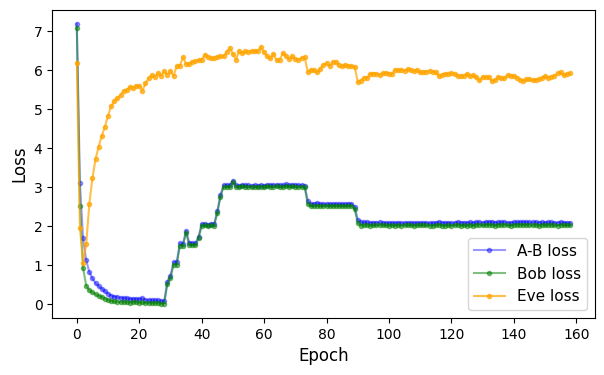

In [ ]:
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], '.-', color='blue', label='A-B loss', alpha=0.4)
plt.plot(boblosses[:steps], '.-', color='green', label='Bob loss', alpha=0.5)
plt.plot(evelosses[:steps], '.-', color='orange', label='Eve loss', alpha=0.7)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=11)

#plt.savefig("images/" + model_name + ".png", transparent=True) #dpi=100
plt.show()

In [ ]:
alice.eval()
bob.eval()
eve.eval()
pass

In [ ]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits) # Use a different key for each message

m_tensor = torch.Tensor(m_batch).to(DEVICE)
k_tensor = torch.Tensor(k_batch).to(DEVICE)

m_enc = alice([m_tensor, k_tensor])
m_dec = (   bob([m_enc, k_tensor]).cpu().detach().numpy() > 0.5   ).astype(int)
m_att = (   eve(m_enc).cpu().detach().numpy() > 0.5   ).astype(int)

bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')

Bob % correct:  5.78 %
Eve % correct:  0.07 %


# Model 1

An update with a modification to the models which increases their learning capacity.

- Additional Dense (FC) at the end of the convolutional portion.

This allows me to use more channels for all Conv layers (notice they all have stride 1 now), and the final Dense layer brings the dimension down to what the output size should be (this removes the restriction on the last Conv having only 1 channel).


## EncoderModel (Alice)

In [ ]:
class EncoderModel(nn.Module):
    def __init__(self, m_bits, k_bits, c_bits, channels=4, kersize=4, pad='same'):
        super().__init__()
        self.m_bits = m_bits
        self.k_bits = k_bits
        self.c_bits = c_bits
        self.channels = 4
        self.kersize = 4

        # Define the initial layers
        self.dense0 = nn.Linear(in_features=m_bits+k_bits, out_features=m_bits+k_bits)
        self.activ0 = nn.Tanh()

        # Define the convolutional operations
        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=channels, kernel_size=kersize, stride=1, padding=pad),
            nn.Tanh(),
            nn.Conv1d(in_channels=channels, out_channels=channels, kernel_size=kersize, stride=1, padding=pad),
            nn.Tanh(),
            nn.Conv1d(in_channels=channels, out_channels=channels, kernel_size=kersize, stride=1, padding=pad),
            nn.Tanh(),
            nn.Conv1d(in_channels=channels, out_channels=channels, kernel_size=kersize, stride=1, padding=pad),
            nn.Tanh()
            #nn.Sigmoid()
        )

        # The output dense layer
        self.dense1 = nn.Linear(in_features=channels*(m_bits+k_bits), out_features=c_bits)
        self.activ1 = nn.Tanh()

    def forward(self, inputs):
        m, k = inputs  # message, key
        #print(m.shape, k.shape)

        # concatenate the inputs, then apply dense
        x = torch.cat([m, k], dim=-1)
        #print(x.shape)
        x = self.activ0(self.dense0(x))

        # reshape to add a "channels" dimension, apply convolutions, then flatten again
        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.flatten(x, start_dim=1)

        # apply the final dense layer
        x = self.activ1(self.dense1(x))
        return x

## DecoderModel (Bob)

In [ ]:
class DecoderModel(nn.Module):
    def __init__(self, m_bits, k_bits, c_bits, channels=4, kersize=4, pad='same'):
        super().__init__()
        self.m_bits = m_bits
        self.k_bits = k_bits
        self.c_bits = c_bits
        self.channels = 4
        self.kersize = 4

        # Define the initial layers
        self.dense0 = nn.Linear(in_features=c_bits+k_bits, out_features=c_bits+k_bits)
        self.activ0 = nn.Tanh()

        # Define the convolutional operations
        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=channels, kernel_size=kersize, stride=1, padding=pad),
            nn.Tanh(),
            nn.Conv1d(in_channels=channels, out_channels=channels, kernel_size=kersize, stride=1, padding=pad),
            nn.Tanh(),
            nn.Conv1d(in_channels=channels, out_channels=channels, kernel_size=kersize, stride=1, padding=pad),
            nn.Tanh(),
            nn.Conv1d(in_channels=channels, out_channels=channels, kernel_size=kersize, stride=1, padding=pad),
            #nn.Sigmoid()
            nn.Tanh()
        )

        # The output dense layer
        self.dense1 = nn.Linear(in_features=channels*(c_bits+k_bits), out_features=m_bits)
        self.activ1 = nn.Sigmoid()

    def forward(self, inputs):
        c, k = inputs  # ciphertext, key
        #print(c.shape, k.shape)

        # concatenate the inputs, then apply dense
        x = torch.cat([c, k], dim=-1)
        x = self.activ0(self.dense0(x))

        # reshape to add a "channels" dimesion, apply convolutions, then flatten again
        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.flatten(x, start_dim=1)

        # apply the final dense layer
        x = self.activ1(self.dense1(x))
        return x

## AdversaryModel (Eve)

In [ ]:
class AdversaryModel(nn.Module):
    def __init__(self, m_bits, c_bits, k_bits, channels=4, kersize=4, pad='same'):
        super().__init__()
        self.m_bits = m_bits
        self.c_bits = c_bits
        self.k_bits = k_bits
        self.channels = 4
        self.kersize = 4

        # Define the initial layers
        self.dense0 = nn.Linear(in_features=c_bits, out_features=c_bits+k_bits)  # only sees the ciphertext
        self.activ0 = nn.Tanh()
        self.dense1 = nn.Linear(in_features=c_bits+k_bits, out_features=m_bits+k_bits)
        self.activ1 = nn.Tanh()

        # Define the convolutional operations
        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=channels, kernel_size=kersize, stride=1, padding=pad),
            nn.Tanh(),
            nn.Conv1d(in_channels=channels, out_channels=channels, kernel_size=kersize, stride=1, padding=pad),
            nn.Tanh(),
            nn.Conv1d(in_channels=channels, out_channels=channels, kernel_size=kersize, stride=1, padding=pad),
            nn.Tanh(),
            nn.Conv1d(in_channels=channels, out_channels=channels, kernel_size=kersize, stride=1, padding=pad),
            #nn.Sigmoid()
            nn.Tanh()
        )

        # The output dense layer
        self.dense2 = nn.Linear(in_features=channels*(m_bits+k_bits), out_features=m_bits)
        self.activ2 = nn.Sigmoid()

    def forward(self, inputs):
        c = inputs  # ciphertext only

        # apply dense layers to the ciphertext
        x = self.activ0(self.dense0(c))
        x = self.activ1(self.dense1(x))

        # reshape to add a "channels" dimesion, apply convolutions, then flatten again
        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.flatten(x, start_dim=1)

        # apply the final dense layer
        x = self.activ2(self.dense2(x))
        return x

# Train

In [ ]:
# Set up the crypto parameters: message, key, and ciphertext bit lengths
# 16 for model 0
m_bits = 16
k_bits = 16
c_bits = 16

pad = 'same'

# Compute the size of the message space
m_train = 2**(m_bits) #+ k_bits)

# For saving
alice_file = 'models/crypto/' + model_name + '-alice.pt'
bob_file = 'models/crypto/' + model_name + '-bob.pt'
eve_file = 'models/crypto/' + model_name + '-eve.pt'

In [ ]:
alice = EncoderModel(m_bits=m_bits, c_bits=c_bits, k_bits=k_bits, channels=4, kersize=4, pad=pad).to(DEVICE)
bob = DecoderModel(m_bits=m_bits, c_bits=c_bits, k_bits=k_bits, channels=4, kersize=4, pad=pad).to(DEVICE)
eve = AdversaryModel(m_bits=m_bits, c_bits=c_bits, k_bits=k_bits, channels=4, kersize=4, pad=pad).to(DEVICE)

In [ ]:
batch_size = 4

m_batch = torch.Tensor(np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)).to(DEVICE)
k_batch = torch.Tensor(np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)).to(DEVICE)

ciphertext = alice((m_batch, k_batch))  # alice gets (message, key)
bobout = bob((ciphertext, k_batch))  # bob gets (ciphertext, key)
eveout = eve(ciphertext)  # eve doesn't see the key, only the ciphertext

ciphertext.shape, bobout.shape, eveout.shape

(torch.Size([4, 16]), torch.Size([4, 16]), torch.Size([4, 16]))

In [ ]:
# Choose an optimizer
#optim_class = torch.optim.RMSprop
optim_class = torch.optim.Adam

# learning rates
alice_lr = 0.001
bob_lr = 0.001
eve_lr = 0.001

abeoptim = optim_class(
    params=[
        {'params': alice.parameters(), 'lr': alice_lr},
        {'params': bob.parameters(), 'lr': bob_lr}
        #{'params': eve.parameters(), 'lr': eve_lr}
    ], lr=0.001  # default LR if not specified in the dictionaries above
)
eveoptim = optim_class(params=eve.parameters(), lr=eve_lr)

In [ ]:
abelosses = []
boblosses = []
evelosses = []

In [ ]:
n_epochs = 60
batch_size = 512
n_batches = m_train // batch_size

abecycles = 1
evecycles = 2

print(f'Training for {n_epochs} epochs with {n_batches} batches of size {batch_size}')

for epoch in range(n_epochs):
    abeloss, bobloss, eveloss = train_single_epoch(
        alice=alice, bob=bob, eve=eve, abeoptim=abeoptim, eveoptim=eveoptim,
        abecycles=abecycles, evecycles=evecycles, batch_size=batch_size
    )
    abelosses.append(abeloss)
    boblosses.append(bobloss)
    evelosses.append(eveloss)

    print(f'Epoch {epoch:3d}: abe={abeloss:.3f} | bob={bobloss:.3f} | eve={eveloss:.3f}')

Training for 60 epochs with 128 batches of size 512
Epoch   0: abe=7.129 | bob=7.080 | eve=6.697
Epoch   1: abe=4.505 | bob=4.286 | eve=4.272
Epoch   2: abe=3.490 | bob=3.123 | eve=3.172
Epoch   3: abe=2.592 | bob=2.147 | eve=2.661
Epoch   4: abe=1.815 | bob=1.461 | eve=3.259
Epoch   5: abe=1.505 | bob=1.234 | eve=3.845
Epoch   6: abe=1.358 | bob=1.150 | eve=4.360
Epoch   7: abe=1.257 | bob=1.086 | eve=4.715
Epoch   8: abe=1.166 | bob=1.006 | eve=4.798
Epoch   9: abe=0.829 | bob=0.679 | eve=4.920
Epoch  10: abe=0.775 | bob=0.624 | eve=4.905
Epoch  11: abe=0.725 | bob=0.584 | eve=5.005
Epoch  12: abe=0.676 | bob=0.563 | eve=5.322
Epoch  13: abe=0.639 | bob=0.524 | eve=5.291
Epoch  14: abe=0.451 | bob=0.344 | eve=5.387
Epoch  15: abe=0.345 | bob=0.243 | eve=5.457
Epoch  16: abe=0.324 | bob=0.230 | eve=5.553
Epoch  17: abe=0.303 | bob=0.214 | eve=5.621
Epoch  18: abe=0.289 | bob=0.206 | eve=5.700
Epoch  19: abe=0.276 | bob=0.198 | eve=5.774
Epoch  20: abe=0.262 | bob=0.187 | eve=5.797
Epo

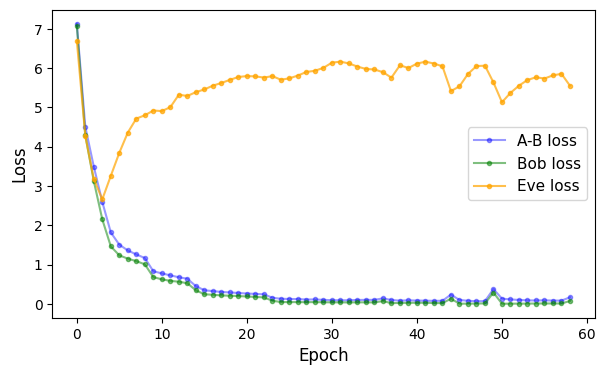

In [ ]:
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], '.-', color='blue', label='A-B loss', alpha=0.4)
plt.plot(boblosses[:steps], '.-', color='green', label='Bob loss', alpha=0.5)
plt.plot(evelosses[:steps], '.-', color='orange', label='Eve loss', alpha=0.7)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=11)

#plt.savefig("images/" + model_name + ".png", transparent=True) #dpi=100
plt.show()

# Evaluate

In [ ]:
alice.eval()
bob.eval()
eve.eval()
pass

In [ ]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits) # Use a different key for each message

m_tensor = torch.Tensor(m_batch).to(DEVICE)
k_tensor = torch.Tensor(k_batch).to(DEVICE)

m_enc = alice([m_tensor, k_tensor])
m_dec = (   bob([m_enc, k_tensor]).cpu().detach().numpy() > 0.5   ).astype(int)
m_att = (   eve(m_enc).cpu().detach().numpy() > 0.5   ).astype(int)

bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')

Bob % correct:  99.99 %
Eve % correct:  0.15 %


# Model 2 (info leak)

Using the same architecture for Eve and Bob, we allow Eve to see some portion of the key.

In [ ]:
# Set up the crypto parameters: message, key, and ciphertext bit lengths
# 16 for model 0
m_bits = 16
k_bits = 16
c_bits = 16
n_leak = 12  # allow Eve to see the bits [0, 1, ..., n_leak-1] in the key

pad = 'same'

# Compute the size of the message space
m_train = 2**(m_bits) #+ k_bits)

In [ ]:
alice = EncoderModel(m_bits=m_bits, c_bits=c_bits, k_bits=k_bits, channels=4, kersize=4, pad=pad).to(DEVICE)
bob = DecoderModel(m_bits=m_bits, c_bits=c_bits, k_bits=k_bits, channels=4, kersize=4, pad=pad).to(DEVICE)

# Now Eve behaves as Bob since she has access to some of the key, so we can simply utilize Bob's architecture
eve = DecoderModel(m_bits=m_bits, c_bits=c_bits, k_bits=k_bits, channels=4, kersize=4, pad=pad).to(DEVICE)

In [ ]:
batch_size = 4

m_batch = torch.Tensor(np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)).to(DEVICE)
k_batch = torch.Tensor(np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)).to(DEVICE)

# zero out keys
k0_batch = torch.clone(k_batch)
k0_batch[:,n_leak:] = 0.0  # allow Eve to see the bits [0, 1, ..., n_leak-1] in the key

# Eve network evaluates as Bob's (yet she gets tke k0_batch)
ciphertext = alice((m_batch, k_batch))  # alice gets (message, key)
bobout = bob((ciphertext, k_batch))  # bob gets (ciphertext, key)
eveout = eve((ciphertext, k0_batch))  # eve doesn't see the key, only the ciphertext

ciphertext.shape, bobout.shape, eveout.shape
k0_batch

tensor([[0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.]])

## Train

In [ ]:
# Choose an optimizer
#optim_class = torch.optim.RMSprop
optim_class = torch.optim.Adam

# learning rates
alice_lr = 0.001
bob_lr = 0.001
eve_lr = 0.001

abeoptim = optim_class(
    params=[
        {'params': alice.parameters(), 'lr': alice_lr},
        {'params': bob.parameters(), 'lr': bob_lr}
        #{'params': eve.parameters(), 'lr': eve_lr}
    ], lr=0.001  # default LR if not specified in the dictionaries above
)
eveoptim = optim_class(params=eve.parameters(), lr=eve_lr)

In [ ]:
abelosses = []
boblosses = []
evelosses = []

In [ ]:
n_epochs = 60
batch_size = 256
n_batches = m_train // batch_size

abecycles = 1
evecycles = 2

print(f'Training for {n_epochs} epochs with {n_batches} batches of size {batch_size}')

for epoch in range(n_epochs):
    abeloss, bobloss, eveloss = train_single_epoch_leaky_v0(
        alice=alice, bob=bob, eve=eve, abeoptim=abeoptim, eveoptim=eveoptim,
        abecycles=abecycles, evecycles=evecycles, n_leak=n_leak, batch_size=batch_size
    )
    abelosses.append(abeloss)
    boblosses.append(bobloss)
    evelosses.append(eveloss)

    print(f'Epoch {epoch:3d}: abe={abeloss:.3f} | bob={bobloss:.3f} | eve={eveloss:.3f}')

Training for 60 epochs with 256 batches of size 256
Epoch   0: abe=5.893 | bob=5.762 | eve=5.480
Epoch   1: abe=3.122 | bob=2.694 | eve=2.777
Epoch   2: abe=2.142 | bob=1.619 | eve=2.236
Epoch   3: abe=1.476 | bob=0.965 | eve=2.293
Epoch   4: abe=0.986 | bob=0.399 | eve=1.878
Epoch   5: abe=0.915 | bob=0.290 | eve=1.693
Epoch   6: abe=0.872 | bob=0.249 | eve=1.687
Epoch   7: abe=0.808 | bob=0.160 | eve=1.566
Epoch   8: abe=0.728 | bob=0.073 | eve=1.529
Epoch   9: abe=0.698 | bob=0.062 | eve=1.620
Epoch  10: abe=0.678 | bob=0.056 | eve=1.711
Epoch  11: abe=0.665 | bob=0.049 | eve=1.726
Epoch  12: abe=0.661 | bob=0.045 | eve=1.720
Epoch  13: abe=0.648 | bob=0.043 | eve=1.782
Epoch  14: abe=0.666 | bob=0.043 | eve=1.686
Epoch  15: abe=0.630 | bob=0.041 | eve=1.860
Epoch  16: abe=0.649 | bob=0.032 | eve=1.721
Epoch  17: abe=0.645 | bob=0.028 | eve=1.712
Epoch  18: abe=0.645 | bob=0.027 | eve=1.713
Epoch  19: abe=0.620 | bob=0.021 | eve=1.801
Epoch  20: abe=0.626 | bob=0.015 | eve=1.753
Epo

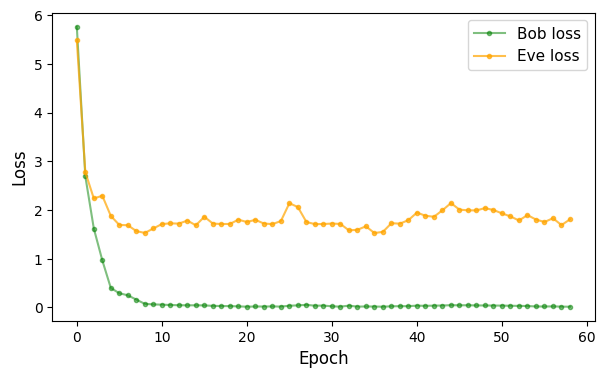

In [ ]:
steps = -1

plt.figure(figsize=(7, 4))
# plt.plot(abelosses[:steps], '.-', color='blue', label='A-B loss', alpha=0.4)
plt.plot(boblosses[:steps], '.-', color='green', label='Bob loss', alpha=0.5)
plt.plot(evelosses[:steps], '.-', color='orange', label='Eve loss', alpha=0.7)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=11)

#plt.savefig("images/" + model_name + ".png", transparent=True) #dpi=100
plt.show()

## Evaluate

In [ ]:
alice.eval()
bob.eval()
eve.eval()
pass

In [ ]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits) # Use a different key for each message

m_tensor = torch.Tensor(m_batch).to(DEVICE)
k_tensor = torch.Tensor(k_batch).to(DEVICE)

# zero out keys
k0_tensor = torch.clone(k_tensor)
k0_tensor[:,n_leak:] = 0.0  # zero out the bits [n_leak, n_leak+1, ...]

m_enc = alice([m_tensor, k_tensor])
m_dec = (   bob([m_enc, k_tensor]).cpu().detach().numpy() > 0.5   ).astype(int)
m_att = (   eve([m_enc, k0_tensor]).cpu().detach().numpy() > 0.5   ).astype(int)

bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')

Bob % correct:  9.65 %
Eve % correct:  0.05 %


# MACs (Message Authenticated Codes)
- Symmetric model.
- Asymmetroc model.

## Symmetric Without MACs (Version 0) - POC (Abadi et al. improved)

Using device: cpu


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(input, weight, bias, self.stride,


Training for 30 epochs
Epoch   0: abe=5.330 | bob=5.071 | eve=4.628
Epoch   1: abe=1.411 | bob=0.943 | eve=2.591
Epoch   2: abe=0.724 | bob=0.494 | eve=4.187
Epoch   3: abe=0.485 | bob=0.325 | eve=4.806
Epoch   4: abe=0.394 | bob=0.244 | eve=4.923
Epoch   5: abe=0.373 | bob=0.244 | eve=5.139
Epoch   6: abe=0.339 | bob=0.231 | eve=5.362
Epoch   7: abe=0.363 | bob=0.252 | eve=5.353
Epoch   8: abe=0.257 | bob=0.159 | eve=5.505
Epoch   9: abe=0.166 | bob=0.061 | eve=5.425
Epoch  10: abe=0.130 | bob=0.050 | eve=5.722
Epoch  11: abe=0.114 | bob=0.048 | eve=5.955
Epoch  12: abe=0.129 | bob=0.065 | eve=6.013
Epoch  13: abe=0.111 | bob=0.042 | eve=5.898
Epoch  14: abe=0.104 | bob=0.041 | eve=6.003
Epoch  15: abe=0.101 | bob=0.039 | eve=5.987
Epoch  16: abe=0.113 | bob=0.048 | eve=5.968
Epoch  17: abe=0.103 | bob=0.041 | eve=5.993
Epoch  18: abe=0.087 | bob=0.027 | eve=6.027
Epoch  19: abe=0.100 | bob=0.041 | eve=6.060
Epoch  20: abe=0.083 | bob=0.021 | eve=6.002
Epoch  21: abe=0.073 | bob=0.017

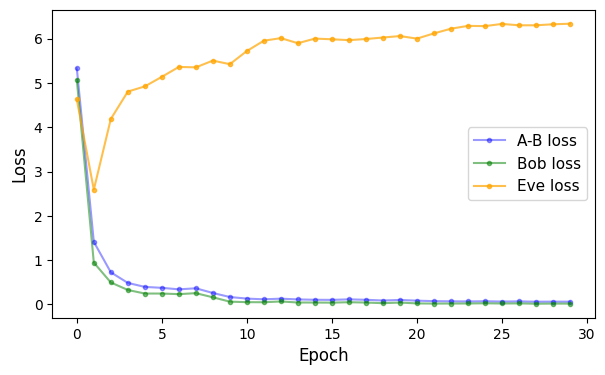

Bob % correct:  98.1 %
Eve % correct:  0.03 %


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

# Generic random batch function
def random_batch(X_train, y_train, batch_size):
    index_set = np.random.randint(0, X_train.shape[0], batch_size)
    X_batch = X_train[index_set]
    y_batch = y_train[index_set]
    return X_batch, y_batch

# Model architectures
class EncoderModel(nn.Module):
    def __init__(self, m_bits, k_bits, pad='same'):
        super().__init__()
        self.m_bits = m_bits
        self.k_bits = k_bits

        self.dense0 = nn.Linear(in_features=m_bits+k_bits, out_features=m_bits+k_bits)
        self.activ0 = nn.Tanh()

        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=4, stride=1, padding=pad),
            nn.BatchNorm1d(2),
            nn.Tanh(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride=2),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=pad),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride=1, padding=pad),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        m, k = inputs
        x = torch.cat([m, k], dim=-1)
        x = self.activ0(self.dense0(x))
        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.squeeze(x, dim=1)
        return x

class DecoderModel(nn.Module):
    def __init__(self, c_bits, k_bits, pad='same'):
        super().__init__()
        self.c_bits = c_bits
        self.k_bits = k_bits

        self.dense0 = nn.Linear(in_features=c_bits+k_bits, out_features=c_bits+k_bits)
        self.activ0 = nn.Tanh()

        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=4, stride=1, padding=pad),
            nn.BatchNorm1d(2),
            nn.Tanh(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride=2),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=pad),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride=1, padding=pad),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        c, k = inputs
        x = torch.cat([c, k], dim=-1)
        x = self.activ0(self.dense0(x))
        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.squeeze(x, dim=1)
        return x

class AdversaryModel(nn.Module):
    def __init__(self, c_bits, k_bits, pad='same'):
        super().__init__()
        self.c_bits = c_bits
        self.k_bits = k_bits

        self.dense0 = nn.Linear(in_features=c_bits, out_features=c_bits+k_bits)
        self.activ0 = nn.Tanh()
        self.dense1 = nn.Linear(in_features=c_bits+k_bits, out_features=c_bits+k_bits)
        self.activ1 = nn.Tanh()

        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=4, stride=1, padding=pad),
            nn.BatchNorm1d(2),
            nn.Tanh(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride=2),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=pad),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride=1, padding=pad),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        c = inputs
        x = self.activ0(self.dense0(c))
        x = self.activ1(self.dense1(x))
        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.squeeze(x, dim=1)
        return x

# Training loop
def train_single_epoch(alice, bob, eve, abeoptim, eveoptim, abecycles, evecycles, batch_size=32, device=DEVICE):
    n_iterations = 2**16 // batch_size
    iteration = 0
    abeloss_sum = 0
    bobloss_sum = 0
    eveloss_sum = 0
    while iteration < n_iterations:
        alice.train()
        bob.train()
        eve.train()
        for param in alice.parameters():
            param.requires_grad = True
        for param in bob.parameters():
            param.requires_grad = True
        for param in eve.parameters():
            param.requires_grad = False

        for _ in range(abecycles):
            m_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(DEVICE)
            k_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(DEVICE)

            ciphertext = alice((m_batch, k_batch))
            bobout = bob((ciphertext, k_batch))
            eveout = eve(ciphertext)

            bobloss = torch.mean(torch.sum(torch.abs(m_batch - bobout), axis=-1))
            bobloss_sum += bobloss.cpu().detach().numpy() / abecycles

            eveloss = torch.mean(torch.sum(torch.abs(m_batch - eveout), axis=-1))
            abeloss = bobloss + torch.square(16/2 - eveloss) / ((16//2)**2)
            abeloss_sum += abeloss.cpu().detach().numpy() / abecycles

            abeoptim.zero_grad()
            abeloss.backward()
            abeoptim.step()

        for param in alice.parameters():
            param.requires_grad = False
        for param in bob.parameters():
            param.requires_grad = False
        for param in eve.parameters():
            param.requires_grad = True

        for _ in range(evecycles):
            m_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(DEVICE)
            k_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(DEVICE)

            ciphertext = alice((m_batch, k_batch))
            eveout = eve(ciphertext)

            eveloss = torch.mean(torch.sum(torch.abs(m_batch - eveout), axis=-1))
            eveloss_sum += eveloss.cpu().detach().numpy() / evecycles

            eveoptim.zero_grad()
            eveloss.backward()
            eveoptim.step()

        iteration += 1

    alice.eval()
    bob.eval()
    eve.eval()
    with torch.inference_mode():
        pass

    return abeloss_sum/n_iterations, bobloss_sum/n_iterations, eveloss_sum/n_iterations

# Model initialization
m_bits = 16
k_bits = 16
c_bits = 16
pad = 'same'

alice = EncoderModel(m_bits=m_bits, k_bits=k_bits, pad=pad).to(DEVICE)
bob = DecoderModel(c_bits=c_bits, k_bits=k_bits, pad=pad).to(DEVICE)
eve = AdversaryModel(c_bits=c_bits, k_bits=k_bits, pad=pad).to(DEVICE)

batch_size = 256

m_batch = torch.Tensor(np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)).to(DEVICE)
k_batch = torch.Tensor(np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)).to(DEVICE)

ciphertext = alice((m_batch, k_batch))
bobout = bob((ciphertext, k_batch))
eveout = eve(ciphertext)

# Optimizers and learning rate schedulers
abeoptim = optim.Adam(
    params=[
        {'params': alice.parameters(), 'lr': 0.001},
        {'params': bob.parameters(), 'lr': 0.001}
    ], lr=0.001
)
eveoptim = optim.Adam(params=eve.parameters(), lr=0.001)

abe_scheduler = optim.lr_scheduler.StepLR(abeoptim, step_size=10, gamma=0.5)
eve_scheduler = optim.lr_scheduler.StepLR(eveoptim, step_size=10, gamma=0.5)

abelosses = []
boblosses = []
evelosses = []

n_epochs = 30
abecycles = 1
evecycles = 2

print(f'Training for {n_epochs} epochs')

for epoch in range(n_epochs):
    abeloss, bobloss, eveloss = train_single_epoch(
        alice=alice, bob=bob, eve=eve, abeoptim=abeoptim, eveoptim=eveoptim,
        abecycles=abecycles, evecycles=evecycles, batch_size=batch_size
    )
    abelosses.append(abeloss)
    boblosses.append(bobloss)
    evelosses.append(eveloss)

    abe_scheduler.step()
    eve_scheduler.step()

    print(f'Epoch {epoch:3d}: abe={abeloss:.3f} | bob={bobloss:.3f} | eve={eveloss:.3f}')

# Plotting the results
plt.figure(figsize=(7, 4))
plt.plot(abelosses, '.-', color='blue', label='A-B loss', alpha=0.4)
plt.plot(boblosses, '.-', color='green', label='Bob loss', alpha=0.5)
plt.plot(evelosses, '.-', color='orange', label='Eve loss', alpha=0.7)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=11)
plt.show()

# Evaluation
alice.eval()
bob.eval()
eve.eval()

n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)

m_tensor = torch.Tensor(m_batch).to(DEVICE)
k_tensor = torch.Tensor(k_batch).to(DEVICE)

m_enc = alice([m_tensor, k_tensor])
m_dec = (bob([m_enc, k_tensor]).cpu().detach().numpy() > 0.5).astype(int)
m_att = (eve(m_enc).cpu().detach().numpy() > 0.5).astype(int)

bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')


Using device: cpu
Training for 30 epochs
Epoch   0: abe=5.801 | bob=5.583 | eve=4.754
Epoch   1: abe=2.012 | bob=1.514 | eve=2.368
Epoch   2: abe=1.047 | bob=0.724 | eve=3.463
Epoch   3: abe=0.656 | bob=0.428 | eve=4.187
Epoch   4: abe=0.474 | bob=0.294 | eve=4.618
Epoch   5: abe=0.384 | bob=0.231 | eve=4.872
Epoch   6: abe=0.298 | bob=0.157 | eve=4.998
Epoch   7: abe=0.254 | bob=0.135 | eve=5.242
Epoch   8: abe=0.279 | bob=0.143 | eve=5.051
Epoch   9: abe=0.205 | bob=0.094 | eve=5.342
Epoch  10: abe=0.161 | bob=0.063 | eve=5.493
Epoch  11: abe=0.149 | bob=0.071 | eve=5.761
Epoch  12: abe=0.142 | bob=0.061 | eve=5.723
Epoch  13: abe=0.137 | bob=0.059 | eve=5.750
Epoch  14: abe=0.126 | bob=0.051 | eve=5.813
Epoch  15: abe=0.121 | bob=0.051 | eve=5.892
Epoch  16: abe=0.124 | bob=0.049 | eve=5.814
Epoch  17: abe=0.114 | bob=0.040 | eve=5.841
Epoch  18: abe=0.112 | bob=0.041 | eve=5.873
Epoch  19: abe=0.119 | bob=0.049 | eve=5.910
Epoch  20: abe=0.096 | bob=0.023 | eve=5.857
Epoch  21: abe

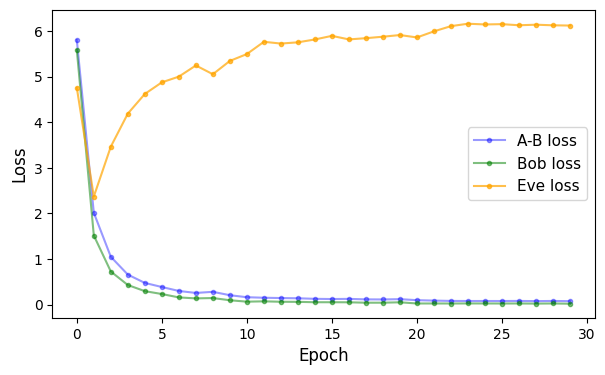

Bob % correct:  97.89 %
Eve % correct:  0.04 %


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

# Generic random batch function
def random_batch(X_train, y_train, batch_size):
    index_set = np.random.randint(0, X_train.shape[0], batch_size)
    X_batch = X_train[index_set]
    y_batch = y_train[index_set]
    return X_batch, y_batch

# Enhanced Model Architectures
class EncoderModel(nn.Module):
    def __init__(self, m_bits, k_bits, pad='same'):
        super().__init__()
        self.m_bits = m_bits
        self.k_bits = k_bits

        self.dense0 = nn.Linear(in_features=m_bits+k_bits, out_features=m_bits+k_bits)
        self.activ0 = nn.Tanh()

        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=4, stride=1, padding=pad),
            nn.BatchNorm1d(2),
            nn.Tanh(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride=2),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=pad),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride=1, padding=pad),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        m, k = inputs
        x = torch.cat([m, k], dim=-1)
        x = self.activ0(self.dense0(x))
        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.squeeze(x, dim=1)
        return x

class DecoderModel(nn.Module):
    def __init__(self, c_bits, k_bits, pad='same'):
        super().__init__()
        self.c_bits = c_bits
        self.k_bits = k_bits

        self.dense0 = nn.Linear(in_features=c_bits+k_bits, out_features=c_bits+k_bits)
        self.activ0 = nn.Tanh()

        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=4, stride=1, padding=pad),
            nn.BatchNorm1d(2),
            nn.Tanh(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride=2),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=pad),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride=1, padding=pad),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        c, k = inputs
        x = torch.cat([c, k], dim=-1)
        x = self.activ0(self.dense0(x))
        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.squeeze(x, dim=1)
        return x

class AdversaryModel(nn.Module):
    def __init__(self, c_bits, k_bits, pad='same'):
        super().__init__()
        self.c_bits = c_bits
        self.k_bits = k_bits

        self.dense0 = nn.Linear(in_features=c_bits, out_features=c_bits+k_bits)
        self.activ0 = nn.Tanh()
        self.dense1 = nn.Linear(in_features=c_bits+k_bits, out_features=c_bits+k_bits)
        self.activ1 = nn.Tanh()

        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=4, stride=1, padding=pad),
            nn.BatchNorm1d(2),
            nn.Tanh(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride=2),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=pad),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride=1, padding=pad),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        c = inputs
        x = self.activ0(self.dense0(c))
        x = self.activ1(self.dense1(x))
        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.squeeze(x, dim=1)
        return x

# Training Loop with Advanced Training Techniques
def train_single_epoch(alice, bob, eve, abeoptim, eveoptim, abecycles, evecycles, batch_size=32, device=DEVICE):
    n_iterations = 2**16 // batch_size
    iteration = 0
    abeloss_sum = 0
    bobloss_sum = 0
    eveloss_sum = 0
    while iteration < n_iterations:
        alice.train()
        bob.train()
        eve.train()
        for param in alice.parameters():
            param.requires_grad = True
        for param in bob.parameters():
            param.requires_grad = True
        for param in eve.parameters():
            param.requires_grad = False

        for _ in range(abecycles):
            m_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(DEVICE)
            k_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(DEVICE)

            ciphertext = alice((m_batch, k_batch))
            bobout = bob((ciphertext, k_batch))
            eveout = eve(ciphertext)

            bobloss = torch.mean(torch.sum(torch.abs(m_batch - bobout), axis=-1))
            bobloss_sum += bobloss.cpu().detach().numpy() / abecycles

            eveloss = torch.mean(torch.sum(torch.abs(m_batch - eveout), axis=-1))
            abeloss = bobloss + torch.square(16/2 - eveloss) / ((16//2)**2)
            abeloss_sum += abeloss.cpu().detach().numpy() / abecycles

            abeoptim.zero_grad()
            abeloss.backward()
            abeoptim.step()

        for param in alice.parameters():
            param.requires_grad = False
        for param in bob.parameters():
            param.requires_grad = False
        for param in eve.parameters():
            param.requires_grad = True

        for _ in range(evecycles):
            m_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(DEVICE)
            k_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(DEVICE)

            ciphertext = alice((m_batch, k_batch))
            eveout = eve(ciphertext)

            eveloss = torch.mean(torch.sum(torch.abs(m_batch - eveout), axis=-1))
            eveloss_sum += eveloss.cpu().detach().numpy() / evecycles

            eveoptim.zero_grad()
            eveloss.backward()
            eveoptim.step()

        iteration += 1

    alice.eval()
    bob.eval()
    eve.eval()
    with torch.no_grad():
        pass

    return abeloss_sum/n_iterations, bobloss_sum/n_iterations, eveloss_sum/n_iterations

# Model Initialization
m_bits = 16
k_bits = 16
c_bits = 16
pad = 'same'

alice = EncoderModel(m_bits=m_bits, k_bits=k_bits, pad=pad).to(DEVICE)
bob = DecoderModel(c_bits=c_bits, k_bits=k_bits, pad=pad).to(DEVICE)
eve = AdversaryModel(c_bits=c_bits, k_bits=k_bits, pad=pad).to(DEVICE)

batch_size = 256

m_batch = torch.Tensor(np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)).to(DEVICE)
k_batch = torch.Tensor(np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)).to(DEVICE)

ciphertext = alice((m_batch, k_batch))
bobout = bob((ciphertext, k_batch))
eveout = eve(ciphertext)

# Optimizers and Learning Rate Schedulers
abeoptim = optim.Adam(
    params=[
        {'params': alice.parameters(), 'lr': 0.001},
        {'params': bob.parameters(), 'lr': 0.001}
    ], lr=0.001
)
eveoptim = optim.Adam(params=eve.parameters(), lr=0.001)

abe_scheduler = optim.lr_scheduler.StepLR(abeoptim, step_size=10, gamma=0.5)
eve_scheduler = optim.lr_scheduler.StepLR(eveoptim, step_size=10, gamma=0.5)

abelosses = []
boblosses = []
evelosses = []

n_epochs = 30
abecycles = 1
evecycles = 2

print(f'Training for {n_epochs} epochs')

for epoch in range(n_epochs):
    abeloss, bobloss, eveloss = train_single_epoch(
        alice=alice, bob=bob, eve=eve, abeoptim=abeoptim, eveoptim=eveoptim,
        abecycles=abecycles, evecycles=evecycles, batch_size=batch_size
    )
    abelosses.append(abeloss)
    boblosses.append(bobloss)
    evelosses.append(eveloss)

    abe_scheduler.step()
    eve_scheduler.step()

    print(f'Epoch {epoch:3d}: abe={abeloss:.3f} | bob={bobloss:.3f} | eve={eveloss:.3f}')

# Plotting the results
plt.figure(figsize=(7, 4))
plt.plot(abelosses, '.-', color='blue', label='A-B loss', alpha=0.4)
plt.plot(boblosses, '.-', color='green', label='Bob loss', alpha=0.5)
plt.plot(evelosses, '.-', color='orange', label='Eve loss', alpha=0.7)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=11)
plt.show()

# Evaluation
alice.eval()
bob.eval()
eve.eval()

n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)

m_tensor = torch.Tensor(m_batch).to(DEVICE)
k_tensor = torch.Tensor(k_batch).to(DEVICE)

m_enc = alice([m_tensor, k_tensor])
m_dec = (bob([m_enc, k_tensor]).cpu().detach().numpy() > 0.5).astype(int)
m_att = (eve(m_enc).cpu().detach().numpy() > 0.5).astype(int)

bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')


In [ ]:
# Generate a very large test set for stress analysis
n_examples_stress = 1000000  # 1 million examples

# Generate random messages and keys
m_batch_stress = np.random.randint(0, 2, m_bits * n_examples_stress).reshape(n_examples_stress, m_bits)
k_batch_stress = np.random.randint(0, 2, k_bits * n_examples_stress).reshape(n_examples_stress, k_bits)

# Convert to tensors
m_tensor_stress = torch.Tensor(m_batch_stress).to(DEVICE)
k_tensor_stress = torch.Tensor(k_batch_stress).to(DEVICE)

# Encrypt the messages
m_enc_stress = alice([m_tensor_stress, k_tensor_stress])

# Bob's and Eve's output
m_dec_stress = (bob([m_enc_stress, k_tensor_stress]).cpu().detach().numpy() > 0.5).astype(int)
m_att_stress = (eve(m_enc_stress).cpu().detach().numpy() > 0.5).astype(int)

# Calculate accuracy for Bob and Eve
bob_correct = np.sum(np.all(m_dec_stress == m_batch_stress, axis=1))
eve_correct = np.sum(np.all(m_att_stress == m_batch_stress, axis=1))

bob_accuracy = 100.0 * bob_correct / n_examples_stress
eve_accuracy = 100.0 * eve_correct / n_examples_stress

print(f'Bob Accuracy on Stress Test: {bob_accuracy:.2f}%')
print(f'Eve Accuracy on Stress Test: {eve_accuracy:.2f}%')

# Bit Error Rate (BER) for Bob and Eve
ber_bob = np.mean(np.abs(m_batch_stress - m_dec_stress))
ber_eve = np.mean(np.abs(m_batch_stress - m_att_stress))

print(f'Bob Bit Error Rate (BER) on Stress Test: {ber_bob:.4f}')
print(f'Eve Bit Error Rate (BER) on Stress Test: {ber_eve:.4f}')


Bob Accuracy on Stress Test: 98.02%
Eve Accuracy on Stress Test: 0.04%
Bob Bit Error Rate (BER) on Stress Test: 0.0013
Eve Bit Error Rate (BER) on Stress Test: 0.3832


*Explanation*

    Stress Analysis: By testing the model with a very large number of messages (1 million in this example), we can evaluate how well the model scales and maintains accuracy under heavy load. The Bit Error Rate (BER) is also calculated to assess the error rate for both Bob and Eve.

This comprehensive analysis helps in understanding the robustness and performance of the improved model against potential attacks and under stress conditions.


# Attacks

- Scenario 1: Eve has full access to the ciphertext but no access to the key. We evaluate her ability to guess the original message bits by generating a confusion matrix and a classification report.

- Scenario 2: Eve has partial access to the key (half of it) in addition to the ciphertext. We modify Eve's model to include partial key information and evaluate her performance using a confusion matrix and classification report.

- Scenario 3: Eve has some knowledge of the original messages and the ciphertext. We provide Eve with a fraction of known messages and ciphertext pairs and modify her model to include this additional information. Her performance is evaluated using a confusion matrix and classification report.

## Scenario 1: Eve has full access to the ciphertext but no access to the key.

Training for 30 epochs (Scenario 1: Eve with full access to ciphertext)
Epoch   0: abe=5.451 | bob=5.162 | eve=4.087
Epoch   1: abe=1.878 | bob=1.387 | eve=2.427
Epoch   2: abe=0.965 | bob=0.665 | eve=3.635
Epoch   3: abe=0.609 | bob=0.406 | eve=4.397
Epoch   4: abe=0.444 | bob=0.281 | eve=4.764
Epoch   5: abe=0.353 | bob=0.211 | eve=4.974
Epoch   6: abe=0.286 | bob=0.159 | eve=5.139
Epoch   7: abe=0.257 | bob=0.131 | eve=5.178
Epoch   8: abe=0.245 | bob=0.121 | eve=5.190
Epoch   9: abe=0.197 | bob=0.087 | eve=5.329
Epoch  10: abe=0.154 | bob=0.064 | eve=5.593
Epoch  11: abe=0.141 | bob=0.065 | eve=5.801
Epoch  12: abe=0.146 | bob=0.068 | eve=5.765
Epoch  13: abe=0.132 | bob=0.055 | eve=5.779
Epoch  14: abe=0.135 | bob=0.059 | eve=5.793
Epoch  15: abe=0.144 | bob=0.057 | eve=5.628
Epoch  16: abe=0.118 | bob=0.040 | eve=5.797
Epoch  17: abe=0.117 | bob=0.044 | eve=5.821
Epoch  18: abe=0.112 | bob=0.040 | eve=5.857
Epoch  19: abe=0.105 | bob=0.035 | eve=5.867
Epoch  20: abe=0.092 | bob=0

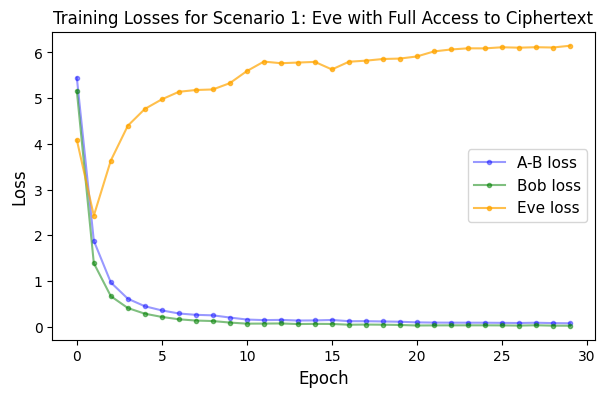

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model definitions (as in the previous implementation)
class EncoderModel(nn.Module):
    def __init__(self, m_bits, k_bits, pad='same'):
        super().__init__()
        self.dense0 = nn.Linear(in_features=m_bits + k_bits, out_features=m_bits + k_bits)
        self.activ0 = nn.Tanh()
        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=4, stride=1, padding=pad),
            nn.BatchNorm1d(2),
            nn.Tanh(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride=2),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=pad),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride=1, padding=pad),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        m, k = inputs
        x = torch.cat([m, k], dim=-1)
        x = self.activ0(self.dense0(x))
        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.squeeze(x, dim=1)
        return x

class DecoderModel(nn.Module):
    def __init__(self, c_bits, k_bits, pad='same'):
        super().__init__()
        self.dense0 = nn.Linear(in_features=c_bits + k_bits, out_features=c_bits + k_bits)
        self.activ0 = nn.Tanh()
        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=4, stride=1, padding=pad),
            nn.BatchNorm1d(2),
            nn.Tanh(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride=2),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=pad),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride=1, padding=pad),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        c, k = inputs
        x = torch.cat([c, k], dim=-1)
        x = self.activ0(self.dense0(x))
        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.squeeze(x, dim=1)
        return x

class AdversaryModel(nn.Module):
    def __init__(self, c_bits, pad='same'):
        super().__init__()
        self.dense0 = nn.Linear(in_features=c_bits, out_features=c_bits + c_bits)
        self.activ0 = nn.Tanh()
        self.dense1 = nn.Linear(in_features=c_bits + c_bits, out_features=c_bits + c_bits)
        self.activ1 = nn.Tanh()

        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=4, stride=1, padding=pad),
            nn.BatchNorm1d(2),
            nn.Tanh(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride=2),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=pad),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride=1, padding=pad),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        c = inputs
        x = self.activ0(self.dense0(c))
        x = self.activ1(self.dense1(x))
        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.squeeze(x, dim=1)
        return x

# Training loop
def train_single_epoch(alice, bob, eve, abeoptim, eveoptim, abecycles, evecycles, batch_size=32, device=DEVICE):
    n_iterations = 2**16 // batch_size
    iteration = 0
    abeloss_sum = 0
    bobloss_sum = 0
    eveloss_sum = 0
    while iteration < n_iterations:
        alice.train()
        bob.train()
        eve.train()
        for param in alice.parameters():
            param.requires_grad = True
        for param in bob.parameters():
            param.requires_grad = True
        for param in eve.parameters():
            param.requires_grad = False

        for _ in range(abecycles):
            m_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(DEVICE)
            k_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(DEVICE)

            ciphertext = alice((m_batch, k_batch))
            bobout = bob((ciphertext, k_batch))
            eveout = eve(ciphertext)

            bobloss = torch.mean(torch.sum(torch.abs(m_batch - bobout), axis=-1))
            bobloss_sum += bobloss.cpu().detach().numpy() / abecycles

            eveloss = torch.mean(torch.sum(torch.abs(m_batch - eveout), axis=-1))
            abeloss = bobloss + torch.square(16/2 - eveloss) / ((16//2)**2)
            abeloss_sum += abeloss.cpu().detach().numpy() / abecycles

            abeoptim.zero_grad()
            abeloss.backward()
            abeoptim.step()

        for param in alice.parameters():
            param.requires_grad = False
        for param in bob.parameters():
            param.requires_grad = False
        for param in eve.parameters():
            param.requires_grad = True

        for _ in range(evecycles):
            m_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(DEVICE)
            k_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(DEVICE)

            ciphertext = alice((m_batch, k_batch))
            eveout = eve(ciphertext)

            eveloss = torch.mean(torch.sum(torch.abs(m_batch - eveout), axis=-1))
            eveloss_sum += eveloss.cpu().detach().numpy() / evecycles

            eveoptim.zero_grad()
            eveloss.backward()
            eveoptim.step()

        iteration += 1

    alice.eval()
    bob.eval()
    eve.eval()
    with torch.no_grad():
        pass

    return abeloss_sum/n_iterations, bobloss_sum/n_iterations, eveloss_sum/n_iterations

# Initialize models
m_bits = 16
k_bits = 16
c_bits = 16
pad = 'same'

alice = EncoderModel(m_bits=m_bits, k_bits=k_bits, pad=pad).to(DEVICE)
bob = DecoderModel(c_bits=c_bits, k_bits=k_bits, pad=pad).to(DEVICE)
eve = AdversaryModel(c_bits=c_bits, pad=pad).to(DEVICE)

# Optimizers and Learning Rate Schedulers
abeoptim = optim.Adam(
    params=[
        {'params': alice.parameters(), 'lr': 0.001},
        {'params': bob.parameters(), 'lr': 0.001}
    ], lr=0.001
)
eveoptim = optim.Adam(params=eve.parameters(), lr=0.001)

abe_scheduler = optim.lr_scheduler.StepLR(abeoptim, step_size=10, gamma=0.5)
eve_scheduler = optim.lr_scheduler.StepLR(eveoptim, step_size=10, gamma=0.5)

abelosses = []
boblosses = []
evelosses = []

n_epochs = 30
abecycles = 1
evecycles = 2

print(f'Training for {n_epochs} epochs (Scenario 1: Eve with full access to ciphertext)')

for epoch in range(n_epochs):
    abeloss, bobloss, eveloss = train_single_epoch(
        alice=alice, bob=bob, eve=eve, abeoptim=abeoptim, eveoptim=eveoptim,
        abecycles=abecycles, evecycles=evecycles, batch_size=256
    )
    abelosses.append(abeloss)
    boblosses.append(bobloss)
    evelosses.append(eveloss)

    abe_scheduler.step()
    eve_scheduler.step()

    print(f'Epoch {epoch:3d}: abe={abeloss:.3f} | bob={bobloss:.3f} | eve={eveloss:.3f}')

# Plotting the results
plt.figure(figsize=(7, 4))
plt.plot(abelosses, '.-', color='blue', label='A-B loss', alpha=0.4)
plt.plot(boblosses, '.-', color='green', label='Bob loss', alpha=0.5)
plt.plot(evelosses, '.-', color='orange', label='Eve loss', alpha=0.7)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=11)
plt.title('Training Losses for Scenario 1: Eve with Full Access to Ciphertext')
plt.show()


## Attack scenario 2:

Eve has partial access to the key in addition to the ciphertext.

Training for 30 epochs (Scenario 2: Eve with partial key access)
Epoch   0: abe=5.690 | bob=5.444 | eve=4.527
Epoch   1: abe=2.149 | bob=1.551 | eve=1.824
Epoch   2: abe=1.210 | bob=0.712 | eve=2.370
Epoch   3: abe=0.893 | bob=0.435 | eve=2.591
Epoch   4: abe=0.751 | bob=0.300 | eve=2.653
Epoch   5: abe=0.656 | bob=0.220 | eve=2.735
Epoch   6: abe=0.624 | bob=0.188 | eve=2.731
Epoch   7: abe=0.549 | bob=0.128 | eve=2.821
Epoch   8: abe=0.545 | bob=0.122 | eve=2.827
Epoch   9: abe=0.522 | bob=0.116 | eve=2.899
Epoch  10: abe=0.490 | bob=0.073 | eve=2.837
Epoch  11: abe=0.466 | bob=0.077 | eve=3.014
Epoch  12: abe=0.455 | bob=0.076 | eve=3.071
Epoch  13: abe=0.447 | bob=0.069 | eve=3.101
Epoch  14: abe=0.514 | bob=0.134 | eve=3.079
Epoch  15: abe=0.427 | bob=0.062 | eve=3.172
Epoch  16: abe=0.420 | bob=0.062 | eve=3.227
Epoch  17: abe=0.406 | bob=0.053 | eve=3.249
Epoch  18: abe=0.393 | bob=0.048 | eve=3.311
Epoch  19: abe=0.407 | bob=0.050 | eve=3.223
Epoch  20: abe=0.381 | bob=0.033 | 

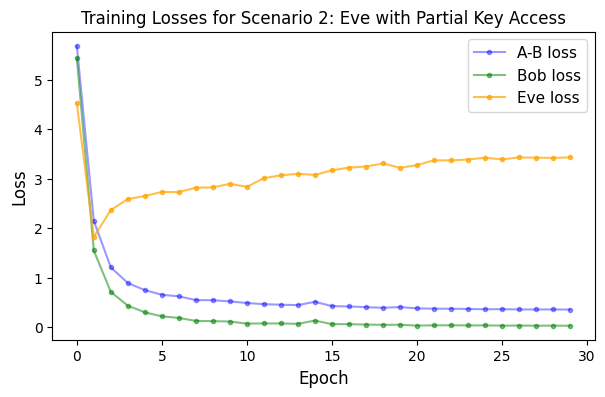

In [ ]:
# Eve has access to half of the key
k_partial = k_batch[:, :k_bits//2]

# Eve's model modified to include partial key
class AdversaryPartialKeyModel(nn.Module):
    def __init__(self, c_bits, k_bits, pad='same'):
        super().__init__()
        self.dense0 = nn.Linear(in_features=c_bits + k_bits//2, out_features=c_bits + k_bits)
        self.activ0 = nn.Tanh()
        self.dense1 = nn.Linear(in_features=c_bits + k_bits, out_features=c_bits + k_bits)
        self.activ1 = nn.Tanh()
        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=4, stride=1, padding=pad),
            nn.BatchNorm1d(2),
            nn.Tanh(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride=2),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=pad),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride=1, padding=pad),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        c, k_partial = inputs
        x = torch.cat([c, k_partial], dim=-1)
        x = self.activ0(self.dense0(x))
        x = self.activ1(self.dense1(x))
        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.squeeze(x, dim=1)
        return x

# Initialize adversary with partial key access
eve_partial = AdversaryPartialKeyModel(c_bits=c_bits, k_bits=k_bits, pad=pad).to(DEVICE)

# Training loop
def train_single_epoch_partial(alice, bob, eve_partial, abeoptim, eveoptim, abecycles, evecycles, batch_size=32, device=DEVICE):
    n_iterations = 2**16 // batch_size
    iteration = 0
    abeloss_sum = 0
    bobloss_sum = 0
    eveloss_sum = 0
    while iteration < n_iterations:
        alice.train()
        bob.train()
        eve_partial.train()
        for param in alice.parameters():
            param.requires_grad = True
        for param in bob.parameters():
            param.requires_grad = True
        for param in eve_partial.parameters():
            param.requires_grad = False

        for _ in range(abecycles):
            m_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(DEVICE)
            k_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(DEVICE)
            k_partial = k_batch[:, :k_bits//2]

            ciphertext = alice((m_batch, k_batch))
            bobout = bob((ciphertext, k_batch))
            eveout = eve_partial((ciphertext, k_partial))

            bobloss = torch.mean(torch.sum(torch.abs(m_batch - bobout), axis=-1))
            bobloss_sum += bobloss.cpu().detach().numpy() / abecycles

            eveloss = torch.mean(torch.sum(torch.abs(m_batch - eveout), axis=-1))
            abeloss = bobloss + torch.square(16/2 - eveloss) / ((16//2)**2)
            abeloss_sum += abeloss.cpu().detach().numpy() / abecycles

            abeoptim.zero_grad()
            abeloss.backward()
            abeoptim.step()

        for param in alice.parameters():
            param.requires_grad = False
        for param in bob.parameters():
            param.requires_grad = False
        for param in eve_partial.parameters():
            param.requires_grad = True

        for _ in range(evecycles):
            m_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(DEVICE)
            k_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(DEVICE)
            k_partial = k_batch[:, :k_bits//2]

            ciphertext = alice((m_batch, k_batch))
            eveout = eve_partial((ciphertext, k_partial))

            eveloss = torch.mean(torch.sum(torch.abs(m_batch - eveout), axis=-1))
            eveloss_sum += eveloss.cpu().detach().numpy() / evecycles

            eveoptim.zero_grad()
            eveloss.backward()
            eveoptim.step()

        iteration += 1

    alice.eval()
    bob.eval()
    eve_partial.eval()
    with torch.no_grad():
        pass

    return abeloss_sum/n_iterations, bobloss_sum/n_iterations, eveloss_sum/n_iterations

# Initialize models
alice = EncoderModel(m_bits=m_bits, k_bits=k_bits, pad=pad).to(DEVICE)
bob = DecoderModel(c_bits=c_bits, k_bits=k_bits, pad=pad).to(DEVICE)

# Optimizers and Learning Rate Schedulers
abeoptim = optim.Adam(
    params=[
        {'params': alice.parameters(), 'lr': 0.001},
        {'params': bob.parameters(), 'lr': 0.001}
    ], lr=0.001
)
eveoptim = optim.Adam(params=eve_partial.parameters(), lr=0.001)

abe_scheduler = optim.lr_scheduler.StepLR(abeoptim, step_size=10, gamma=0.5)
eve_scheduler = optim.lr_scheduler.StepLR(eveoptim, step_size=10, gamma=0.5)

abelosses = []
boblosses = []
evelosses = []

n_epochs = 30
abecycles = 1
evecycles = 2

print(f'Training for {n_epochs} epochs (Scenario 2: Eve with partial key access)')

for epoch in range(n_epochs):
    abeloss, bobloss, eveloss = train_single_epoch_partial(
        alice=alice, bob=bob, eve_partial=eve_partial, abeoptim=abeoptim, eveoptim=eveoptim,
        abecycles=abecycles, evecycles=evecycles, batch_size=256
    )
    abelosses.append(abeloss)
    boblosses.append(bobloss)
    evelosses.append(eveloss)

    abe_scheduler.step()
    eve_scheduler.step()

    print(f'Epoch {epoch:3d}: abe={abeloss:.3f} | bob={bobloss:.3f} | eve={eveloss:.3f}')

# Plotting the results
plt.figure(figsize=(7, 4))
plt.plot(abelosses, '.-', color='blue', label='A-B loss', alpha=0.4)
plt.plot(boblosses, '.-', color='green', label='Bob loss', alpha=0.5)
plt.plot(evelosses, '.-', color='orange', label='Eve loss', alpha=0.7)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=11)
plt.title('Training Losses for Scenario 2: Eve with Partial Key Access')
plt.show()


## Attack scenario 3:

Eve has some knowledge of the original messages and the ciphertext.

Training for 30 epochs (Scenario 3: Eve with some knowledge of original messages)
Epoch   0: abe=5.679 | bob=5.496 | eve=5.217
Epoch   1: abe=2.084 | bob=1.531 | eve=2.055
Epoch   2: abe=1.079 | bob=0.686 | eve=3.010
Epoch   3: abe=0.754 | bob=0.522 | eve=4.159
Epoch   4: abe=0.620 | bob=0.432 | eve=4.543
Epoch   5: abe=0.498 | bob=0.365 | eve=5.098
Epoch   6: abe=0.492 | bob=0.384 | eve=5.376
Epoch   7: abe=0.423 | bob=0.306 | eve=5.285
Epoch   8: abe=0.461 | bob=0.373 | eve=5.666
Epoch   9: abe=0.394 | bob=0.291 | eve=5.421
Epoch  10: abe=0.359 | bob=0.284 | eve=5.823
Epoch  11: abe=0.348 | bob=0.286 | eve=6.012
Epoch  12: abe=0.346 | bob=0.288 | eve=6.078
Epoch  13: abe=0.334 | bob=0.278 | eve=6.114
Epoch  14: abe=0.363 | bob=0.303 | eve=6.046
Epoch  15: abe=1.287 | bob=1.219 | eve=5.920
Epoch  16: abe=1.122 | bob=1.063 | eve=6.070
Epoch  17: abe=0.328 | bob=0.269 | eve=6.057
Epoch  18: abe=0.320 | bob=0.271 | eve=6.251
Epoch  19: abe=0.422 | bob=0.365 | eve=6.077
Epoch  20: abe=0.3

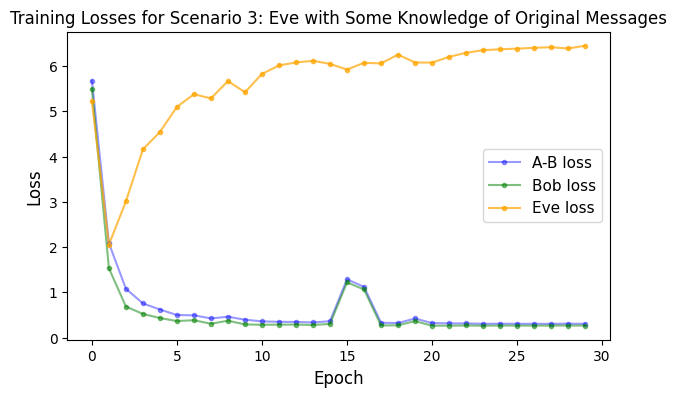

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model definitions (as in the previous implementation)
class EncoderModel(nn.Module):
    def __init__(self, m_bits, k_bits, pad='same'):
        super().__init__()
        self.dense0 = nn.Linear(in_features=m_bits + k_bits, out_features=m_bits + k_bits)
        self.activ0 = nn.Tanh()
        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=4, stride=1, padding=pad),
            nn.BatchNorm1d(2),
            nn.Tanh(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride=2),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=pad),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride=1, padding=pad),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        m, k = inputs
        x = torch.cat([m, k], dim=-1)
        x = self.activ0(self.dense0(x))
        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.squeeze(x, dim=1)
        return x

class DecoderModel(nn.Module):
    def __init__(self, c_bits, k_bits, pad='same'):
        super().__init__()
        self.dense0 = nn.Linear(in_features=c_bits + k_bits, out_features=c_bits + k_bits)
        self.activ0 = nn.Tanh()
        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=4, stride=1, padding=pad),
            nn.BatchNorm1d(2),
            nn.Tanh(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride=2),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=pad),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride=1, padding=pad),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        c, k = inputs
        x = torch.cat([c, k], dim=-1)
        x = self.activ0(self.dense0(x))
        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.squeeze(x, dim=1)
        return x

class AdversaryKnownMessagesModel(nn.Module):
    def __init__(self, c_bits, m_bits, pad='same'):
        super().__init__()
        self.dense0 = nn.Linear(in_features=c_bits + m_bits, out_features=c_bits + m_bits)
        self.activ0 = nn.Tanh()
        self.dense1 = nn.Linear(in_features=c_bits + m_bits, out_features=c_bits + m_bits)
        self.activ1 = nn.Tanh()
        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=4, stride=1, padding=pad),
            nn.BatchNorm1d(2),
            nn.Tanh(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride=2),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=pad),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride=1, padding=pad),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        c, m_known = inputs
        x = torch.cat([c, m_known], dim=-1)
        x = self.activ0(self.dense0(x))
        x = self.activ1(self.dense1(x))
        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.squeeze(x, dim=1)
        return x

# Initialize models
m_bits = 16
k_bits = 16
c_bits = 16
pad = 'same'

alice = EncoderModel(m_bits=m_bits, k_bits=k_bits, pad=pad).to(DEVICE)
bob = DecoderModel(c_bits=c_bits, k_bits=k_bits, pad=pad).to(DEVICE)
eve_known = AdversaryKnownMessagesModel(c_bits=c_bits, m_bits=m_bits, pad=pad).to(DEVICE)

# Optimizers and Learning Rate Schedulers
abeoptim = optim.Adam(
    params=[
        {'params': alice.parameters(), 'lr': 0.001},
        {'params': bob.parameters(), 'lr': 0.001}
    ], lr=0.001
)
eveoptim = optim.Adam(params=eve_known.parameters(), lr=0.001)

abe_scheduler = optim.lr_scheduler.StepLR(abeoptim, step_size=10, gamma=0.5)
eve_scheduler = optim.lr_scheduler.StepLR(eveoptim, step_size=10, gamma=0.5)

abelosses = []
boblosses = []
evelosses = []

n_epochs = 30
abecycles = 1
evecycles = 2

# Generate random messages and keys
n_examples = 10000
m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, k_bits * n_examples).reshape(n_examples, k_bits)

# Convert to tensors
m_tensor = torch.Tensor(m_batch).to(DEVICE)
k_tensor = torch.Tensor(k_batch).to(DEVICE)

# Encrypt the messages
m_enc = alice([m_tensor, k_tensor])

# Generate known messages for Eve
known_messages_fraction = 0.1  # Eve knows 10% of the messages
n_known = int(n_examples * known_messages_fraction)
known_messages = m_batch[:n_known]
known_ciphertexts = m_enc[:n_known].cpu().detach().numpy()

# Training loop
def train_single_epoch_known(alice, bob, eve_known, abeoptim, eveoptim, abecycles, evecycles, batch_size=32, device=DEVICE):
    n_iterations = 2**16 // batch_size
    iteration = 0
    abeloss_sum = 0
    bobloss_sum = 0
    eveloss_sum = 0
    while iteration < n_iterations:
        alice.train()
        bob.train()
        eve_known.train()
        for param in alice.parameters():
            param.requires_grad = True
        for param in bob.parameters():
            param.requires_grad = True
        for param in eve_known.parameters():
            param.requires_grad = False

        for _ in range(abecycles):
            m_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(DEVICE)
            k_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(DEVICE)

            # Concatenate with known messages
            m_known = torch.Tensor(known_messages[:batch_size]).to(DEVICE)

            ciphertext = alice((m_batch, k_batch))
            bobout = bob((ciphertext, k_batch))
            eveout = eve_known((ciphertext, m_known))

            bobloss = torch.mean(torch.sum(torch.abs(m_batch - bobout), axis=-1))
            bobloss_sum += bobloss.cpu().detach().numpy() / abecycles

            eveloss = torch.mean(torch.sum(torch.abs(m_batch - eveout), axis=-1))
            abeloss = bobloss + torch.square(16/2 - eveloss) / ((16//2)**2)
            abeloss_sum += abeloss.cpu().detach().numpy() / abecycles

            abeoptim.zero_grad()
            abeloss.backward()
            abeoptim.step()

        for param in alice.parameters():
            param.requires_grad = False
        for param in bob.parameters():
            param.requires_grad = False
        for param in eve_known.parameters():
            param.requires_grad = True

        for _ in range(evecycles):
            m_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(DEVICE)
            k_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(DEVICE)

            # Concatenate with known messages
            m_known = torch.Tensor(known_messages[:batch_size]).to(DEVICE)

            ciphertext = alice((m_batch, k_batch))
            eveout = eve_known((ciphertext, m_known))

            eveloss = torch.mean(torch.sum(torch.abs(m_batch - eveout), axis=-1))
            eveloss_sum += eveloss.cpu().detach().numpy() / evecycles

            eveoptim.zero_grad()
            eveloss.backward()
            eveoptim.step()

        iteration += 1

    alice.eval()
    bob.eval()
    eve_known.eval()
    with torch.no_grad():
        pass

    return abeloss_sum/n_iterations, bobloss_sum/n_iterations, eveloss_sum/n_iterations

print(f'Training for {n_epochs} epochs (Scenario 3: Eve with some knowledge of original messages)')

for epoch in range(n_epochs):
    abeloss, bobloss, eveloss = train_single_epoch_known(
        alice=alice, bob=bob, eve_known=eve_known, abeoptim=abeoptim, eveoptim=eveoptim,
        abecycles=abecycles, evecycles=evecycles, batch_size=256
    )
    abelosses.append(abeloss)
    boblosses.append(bobloss)
    evelosses.append(eveloss)

    abe_scheduler.step()
    eve_scheduler.step()

    print(f'Epoch {epoch:3d}: abe={abeloss:.3f} | bob={bobloss:.3f} | eve={eveloss:.3f}')

# Plotting the results
plt.figure(figsize=(7, 4))
plt.plot(abelosses, '.-', color='blue', label='A-B loss', alpha=0.4)
plt.plot(boblosses, '.-', color='green', label='Bob loss', alpha=0.5)
plt.plot(evelosses, '.-', color='orange', label='Eve loss', alpha=0.7)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=11)
plt.title('Training Losses for Scenario 3: Eve with Some Knowledge of Original Messages')
plt.show()


We now build upon the previous work and push our ideas forward. We can focus on enhancing the model's robustness, usability, and performance. Here are a few areas where we can make improvements:

    Enhanced Model Architectures:
        Implement more sophisticated layers like attention mechanisms.
        Add residual connections for better gradient flow.

    Advanced Training Techniques:
        Use curriculum learning to gradually increase task difficulty.
        Implement dynamic learning rate adjustments.

    Improved Evaluation Metrics:
        Use additional metrics like the Bit Error Rate (BER) and security margins.

    Usability Enhancements:
        Develop a user interface for easier interaction with the models.
        Optimize the models for scalability and real-world integration.

         Let's focus on implementing the enhanced model architectures with attention mechanisms and residual connections. Below is the updated EncoderModel with attention mechanisms and residual connections.


# The Idea of MACs Popped after a cryptography class

With the increasing complexity of cryptographic attacks, there is a growing need for encryption methods that not only protect the confidentiality of data but also ensure its integrity. This study explores the integration of authenticated encryption into adversarial neural networks, providing a dual-layer security approach.

- This research presents an enhanced adversarial neural network model incorporating authenticated encryption to ensure both data confidentiality and integrity. By integrating a Message Authentication Code (MAC) generation and verification process within the neural network, we improve the robustness and security of the model against tampering and unauthorized access.


### Proposed Scheme for Authenticated Encryption with Adversarial Neural Networks

- In this work, we enhance the existing adversarial neural network model by integrating authenticated encryption (AE) to ensure both confidentiality and integrity of the data. Our proposed scheme includes modifications to the encoder (Alice) to generate a Message Authentication Code (MAC) along with the ciphertext, and the decoder (Bob) to verify the MAC before decrypting the ciphertext. We also train the adversary (Eve) to attempt to tamper with the ciphertext and MAC, making the system robust against such attacks.



## Symmetric version (0)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

class EncoderModelWithMAC(nn.Module):
    def __init__(self, m_bits, k_bits, pad='same'):
        super().__init__()
        self.m_bits = m_bits
        self.k_bits = k_bits

        # Encryption part
        self.dense0 = nn.Linear(in_features=m_bits + k_bits, out_features=m_bits + k_bits)
        self.activ0 = nn.Tanh()

        self.attn = nn.MultiheadAttention(embed_dim=m_bits + k_bits, num_heads=4)
        self.norm1 = nn.LayerNorm(m_bits + k_bits)

        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=4, stride=1, padding=pad),
            nn.BatchNorm1d(2),
            nn.Tanh(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride=2),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=pad),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride=1, padding=pad),
            nn.Sigmoid()
        )

        # MAC part
        self.mac_dense = nn.Linear(in_features=m_bits, out_features=m_bits // 2)
        self.mac_out = nn.Linear(in_features=m_bits // 2, out_features=m_bits)

    def forward(self, inputs):
        m, k = inputs
        x = torch.cat([m, k], dim=-1)
        x = self.activ0(self.dense0(x))

        x = x.unsqueeze(0)  # Add batch dimension
        x, _ = self.attn(x, x, x)
        x = self.norm1(x)
        x = x.squeeze(0)  # Remove batch dimension

        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.squeeze(x, dim=1)

        # Generate MAC
        mac = self.activ0(self.mac_dense(m))
        mac = self.mac_out(mac)
        print(mac)

        return x, mac

class DecoderModelWithMAC(nn.Module):
    def __init__(self, c_bits, k_bits, pad='same'):
        super().__init__()
        self.c_bits = c_bits
        self.k_bits = k_bits

        self.dense0 = nn.Linear(in_features=c_bits + k_bits, out_features=c_bits + k_bits)
        self.activ0 = nn.Tanh()

        self.attn = nn.MultiheadAttention(embed_dim=c_bits + k_bits, num_heads=4)
        self.norm1 = nn.LayerNorm(c_bits + k_bits)

        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=4, stride=1, padding=pad),
            nn.BatchNorm1d(2),
            nn.Tanh(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride=2),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=pad),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride=1, padding=pad),
            nn.Sigmoid()
        )

        # MAC verification part
        self.mac_dense = nn.Linear(in_features=c_bits, out_features=c_bits // 2)
        self.mac_out = nn.Linear(in_features=c_bits // 2, out_features=c_bits)

    def forward(self, inputs):
        c, k, m_true = inputs
        x = torch.cat([c, k], dim=-1)
        x = self.activ0(self.dense0(x))

        x = x.unsqueeze(0)  # Add batch dimension
        x, _ = self.attn(x, x, x)
        x = self.norm1(x)
        x = x.squeeze(0)  # Remove batch dimension

        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.squeeze(x, dim=1)

        # Verify MAC
        mac = self.activ0(self.mac_dense(x))
        mac = self.mac_out(mac)

        mac_valid = torch.allclose(mac, m_true)

        return x, mac_valid

class AdversaryModelWithMAC(nn.Module):
    def __init__(self, c_bits, pad='same'):
        super().__init__()
        self.c_bits = c_bits

        self.dense0 = nn.Linear(in_features=c_bits, out_features=c_bits + c_bits)
        self.activ0 = nn.Tanh()
        self.dense1 = nn.Linear(in_features=c_bits + c_bits, out_features=c_bits + c_bits)
        self.activ1 = nn.Tanh()

        self.attn = nn.MultiheadAttention(embed_dim=c_bits + c_bits, num_heads=4)
        self.norm1 = nn.LayerNorm(c_bits + c_bits)

        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=4, stride=1, padding=pad),
            nn.BatchNorm1d(2),
            nn.Tanh(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride=2),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=pad),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride=1, padding=pad),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        c = inputs
        x = self.activ0(self.dense0(c))
        x = self.activ1(self.dense1(x))

        x = x.unsqueeze(0)  # Add batch dimension
        x, _ = self.attn(x, x, x)
        x = self.norm1(x)
        x = x.squeeze(0)  # Remove batch dimension

        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.squeeze(x, dim=1)

        return x


  # Training loop with authenticated encryption
def train_single_epoch_with_mac(alice, bob, eve, abeoptim, eveoptim, abecycles, evecycles, batch_size=32, device='cuda'):
    n_iterations = 2**16 // batch_size
    iteration = 0
    abeloss_sum = 0
    bobloss_sum = 0
    eveloss_sum = 0
    while iteration < n_iterations:
        alice.train()
        bob.train()
        eve.train()
        for param in alice.parameters():
            param.requires_grad = True
        for param in bob.parameters():
            param.requires_grad = True
        for param in eve.parameters():
            param.requires_grad = False

        for _ in range(abecycles):
            m_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(device)
            k_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(device)

            ciphertext, mac = alice((m_batch, k_batch))
            bobout, mac_valid = bob((ciphertext, k_batch, mac))
            eveout = eve(ciphertext)

            bobloss = torch.mean(torch.sum(torch.abs(m_batch - bobout), axis=-1))
            bobloss_sum += bobloss.cpu().detach().numpy() / abecycles

            eveloss = torch.mean(torch.sum(torch.abs(m_batch - eveout), axis=-1))
            abeloss = bobloss + torch.square(16/2 - eveloss) / ((16//2)**2)
            abeloss_sum += abeloss.cpu().detach().numpy() / abecycles

            abeoptim.zero_grad()
            abeloss.backward()
            abeoptim.step()

        for param in alice.parameters():
            param.requires_grad = False
        for param in bob.parameters():
            param.requires_grad = False
        for param in eve.parameters():
            param.requires_grad = True

        for _ in range(evecycles):
            m_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(device)
            k_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(device)

            ciphertext = alice((m_batch, k_batch))[0]
            eveout = eve(ciphertext)

            eveloss = torch.mean(torch.sum(torch.abs(m_batch - eveout), axis=-1))
            eveloss_sum += eveloss.cpu().detach().numpy() / evecycles

            eveoptim.zero_grad()
            eveloss.backward()
            eveoptim.step()

        iteration += 1

    alice.eval()
    bob.eval()
    eve.eval()
    with torch.no_grad():
        pass

    return abeloss_sum/n_iterations, bobloss_sum/n_iterations, eveloss_sum/n_iterations

# Initialize models
m_bits = 16
k_bits = 16
c_bits = 16
pad = 'same'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

alice = EncoderModelWithMAC(m_bits=m_bits, k_bits=k_bits, pad=pad).to(device)
bob = DecoderModelWithMAC(c_bits=c_bits, k_bits=k_bits, pad=pad).to(device)
eve = AdversaryModelWithMAC(c_bits=c_bits, pad=pad).to(device)

# Optimizers and Learning Rate Schedulers
abeoptim = optim.Adam(
    params=[
        {'params': alice.parameters(), 'lr': 0.001},
        {'params': bob.parameters(), 'lr': 0.001}
    ], lr=0.001
)
eveoptim = optim.Adam(params=eve.parameters(), lr=0.001)

abe_scheduler = optim.lr_scheduler.StepLR(abeoptim, step_size=10, gamma=0.5)
eve_scheduler = optim.lr_scheduler.StepLR(eveoptim, step_size=10, gamma=0.5)

abelosses = []
boblosses = []
evelosses = []

n_epochs = 10
abecycles = 1
evecycles = 2

print(f'Training for {n_epochs} epochs with authenticated encryption')

for epoch in range(n_epochs):
    abeloss, bobloss, eveloss = train_single_epoch_with_mac(
        alice=alice, bob=bob, eve=eve, abeoptim=abeoptim, eveoptim=eveoptim,
        abecycles=abecycles, evecycles=evecycles, batch_size=256, device=device
    )
    abelosses.append(abeloss)
    boblosses.append(bobloss)
    evelosses.append(eveloss)

    abe_scheduler.step()
    eve_scheduler.step()

    print(f'Epoch {epoch:3d}: abe={abeloss:.3f} | bob={bobloss:.3f} | eve={eveloss:.3f}')



Training for 10 epochs with authenticated encryption


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(input, weight, bias, self.stride,


Streaming output truncated to the last 5000 lines.
        [-0.1695,  0.0824, -0.0100,  ..., -0.2914, -0.3284,  0.1687]])
tensor([[-0.3824,  0.2502,  0.1260,  ..., -0.3099, -0.1500, -0.0094],
        [-0.2479,  0.2219, -0.1219,  ..., -0.5572, -0.2311,  0.1319],
        [-0.2087,  0.1598, -0.0400,  ..., -0.3370, -0.2225,  0.1506],
        ...,
        [-0.3507,  0.1423,  0.0603,  ..., -0.5288, -0.2897, -0.0020],
        [-0.5614,  0.2642,  0.1699,  ..., -0.3764, -0.1914, -0.0824],
        [-0.2479,  0.2846, -0.0492,  ..., -0.3951, -0.2575,  0.1429]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.5990,  0.2870,  0.0929,  ..., -0.5534, -0.2729, -0.0918],
        [-0.2453,  0.3000, -0.0166,  ..., -0.4740, -0.2532,  0.1019],
        [-0.1523,  0.2844, -0.0643,  ..., -0.4254, -0.3470,  0.1905],
        ...,
        [-0.2381,  0.1404, -0.0406,  ..., -0.3279, -0.3744,  0.1679],
        [-0.3795,  0.1035,  0.1236,  ..., -0.4827, -0.3220, -0.0285],
        [-0.5316,  0.1809,  0.0177,  ..., -0.376

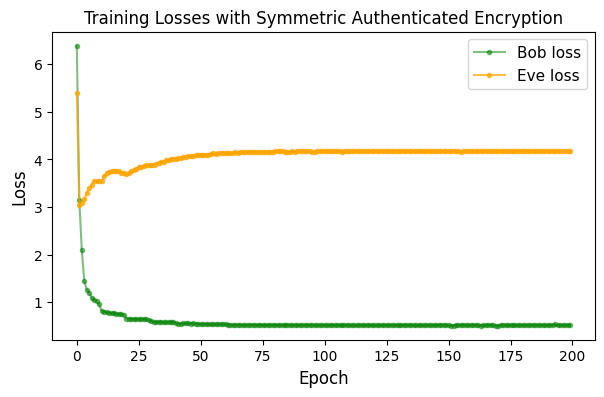

In [ ]:
# Plotting the results
plt.figure(figsize=(7, 4))
# plt.plot(abelosses, '.-', color='blue', label='A-B loss', alpha=0.4)
plt.plot(boblosses, '.-', color='green', label='Bob loss', alpha=0.5)
plt.plot(evelosses, '.-', color='orange', label='Eve loss', alpha=0.7)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=11)
plt.title('Training Losses with Symmetric Authenticated Encryption')

# plt.tight_layout()
plt.show()



# Asymmetric Authenticated Encryption Model (Version 0)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# Key Generator
class KeyPair:
    def __init__(self, key_size):
        self.public_key = torch.rand(key_size)  # Placeholder for public key
        self.private_key = torch.rand(key_size)  # Placeholder for private key

# Generate key pairs for Alice and Bob
alice_keys = KeyPair(key_size=16)
bob_keys = KeyPair(key_size=16)


class AsymmetricEncoderModel(nn.Module):
    def __init__(self, m_bits, k_bits, pad='same'):
        super().__init__()
        self.m_bits = m_bits
        self.k_bits = k_bits

        # Encryption part
        self.dense0 = nn.Linear(in_features=m_bits + k_bits, out_features=m_bits + k_bits)
        self.activ0 = nn.Tanh()

        self.attn = nn.MultiheadAttention(embed_dim=m_bits + k_bits, num_heads=4)
        self.norm1 = nn.LayerNorm(m_bits + k_bits)

        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=4, stride=1, padding=pad),
            nn.BatchNorm1d(2),
            nn.Tanh(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride=2),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=pad),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride=1, padding=pad),
            nn.Sigmoid()
        )

        # MAC part
        self.mac_dense = nn.Linear(in_features=m_bits, out_features=m_bits // 2)
        self.mac_out = nn.Linear(in_features=m_bits // 2, out_features=m_bits)

    def forward(self, inputs, pub_key):
        m, priv_key = inputs
        pub_key_expanded = pub_key.unsqueeze(0).expand(m.size(0), -1).to(device)  # Expand public key to match batch size
        x = torch.cat([m, pub_key_expanded], dim=-1)  # Use the public key for encryption
        x = self.activ0(self.dense0(x))

        x = x.unsqueeze(0)  # Add batch dimension
        x, _ = self.attn(x, x, x)
        x = self.norm1(x)
        x = x.squeeze(0)  # Remove batch dimension

        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.squeeze(x, dim=1)

        # Generate MAC
        mac = self.activ0(self.mac_dense(m))
        mac = self.mac_out(mac)

        return x, mac

class AsymmetricDecoderModel(nn.Module):
    def __init__(self, c_bits, k_bits, pad='same'):
        super().__init__()
        self.c_bits = c_bits
        self.k_bits = k_bits

        self.dense0 = nn.Linear(in_features=c_bits + k_bits, out_features=c_bits + k_bits)
        self.activ0 = nn.Tanh()

        self.attn = nn.MultiheadAttention(embed_dim=c_bits + k_bits, num_heads=4)
        self.norm1 = nn.LayerNorm(c_bits + k_bits)

        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=4, stride=1, padding=pad),
            nn.BatchNorm1d(2),
            nn.Tanh(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride=2),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=pad),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride=1, padding=pad),
            nn.Sigmoid()
        )

        # MAC verification part
        self.mac_dense = nn.Linear(in_features=c_bits, out_features=c_bits // 2)
        self.mac_out = nn.Linear(in_features=c_bits // 2, out_features=c_bits)

    def forward(self, inputs, priv_key, pub_key):
        c, mac_received, m_true = inputs
        priv_key_expanded = priv_key.unsqueeze(0).expand(c.size(0), -1)  # Expand private key to match batch size
        x = torch.cat([c, priv_key_expanded], dim=-1)  # Use the private key for decryption
        x = self.activ0(self.dense0(x))

        x = x.unsqueeze(0)  # Add batch dimension
        x, _ = self.attn(x, x, x)
        x = self.norm1(x)
        x = x.squeeze(0)  # Remove batch dimension

        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.squeeze(x, dim=1)

        # Verify MAC
        mac = self.activ0(self.mac_dense(x))
        mac = self.mac_out(mac)

        mac_valid = torch.allclose(mac, mac_received)

        return x, mac_valid


class AsymmetricAdversaryModel(nn.Module):
    def __init__(self, c_bits, pad='same'):
        super().__init__()
        self.c_bits = c_bits

        self.dense0 = nn.Linear(in_features=c_bits, out_features=c_bits + c_bits)
        self.activ0 = nn.Tanh()
        self.dense1 = nn.Linear(in_features=c_bits + c_bits, out_features=c_bits + c_bits)
        self.activ1 = nn.Tanh()

        self.attn = nn.MultiheadAttention(embed_dim=c_bits + c_bits, num_heads=4)
        self.norm1 = nn.LayerNorm(c_bits + c_bits)

        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=4, stride=1, padding=pad),
            nn.BatchNorm1d(2),
            nn.Tanh(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride=2),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=pad),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride=1, padding=pad),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        c = inputs
        x = self.activ0(self.dense0(c))
        x = self.activ1(self.dense1(x))

        x = x.unsqueeze(0)  # Add batch dimension
        x, _ = self.attn(x, x, x)
        x = self.norm1(x)
        x = x.squeeze(0)  # Remove batch dimension

        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.squeeze(x, dim=1)

        return x


In [ ]:
def train_single_epoch_two_way(alice, bob, eve, abeoptim, eveoptim, abecycles, evecycles, batch_size=32, device='cuda'):
    n_iterations = 2**16 // batch_size
    iteration = 0
    alice_to_bob_abeloss_sum = 0
    bob_to_alice_abeloss_sum = 0
    alice_to_bob_bobloss_sum = 0
    bob_to_alice_aliceloss_sum = 0
    eveloss_sum = 0

    while iteration < n_iterations:
        alice.train()
        bob.train()
        eve.train()
        for param in alice.parameters():
            param.requires_grad = True
        for param in bob.parameters():
            param.requires_grad = True
        for param in eve.parameters():
            param.requires_grad = False

        # Phase 1: Alice to Bob
        for _ in range(abecycles):
            m_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(device)

            # Alice encrypts with Bob's public key
            ciphertext, mac = alice((m_batch, alice_keys.private_key), bob_keys.public_key)
            # Bob decrypts with his private key and verifies MAC
            bobout, mac_valid = bob((ciphertext, mac, m_batch), bob_keys.private_key, alice_keys.public_key)
            # Eve tries to decrypt the ciphertext
            eveout = eve(ciphertext)

            bobloss = torch.mean(torch.sum(torch.abs(m_batch - bobout), axis=-1))
            alice_to_bob_bobloss_sum += bobloss.cpu().detach().numpy() / abecycles

            eveloss = torch.mean(torch.sum(torch.abs(m_batch - eveout), axis=-1))
            abeloss = bobloss + torch.square(16/2 - eveloss) / ((16//2)**2)
            alice_to_bob_abeloss_sum += abeloss.cpu().detach().numpy() / abecycles

            abeoptim.zero_grad()
            abeloss.backward()
            abeoptim.step()

        # Phase 2: Bob to Alice
        for _ in range(abecycles):
            m_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(device)

            # Bob encrypts with Alice's public key
            ciphertext, mac = alice((m_batch, bob_keys.private_key), alice_keys.public_key)
            # Alice decrypts with her private key and verifies MAC
            aliceout, mac_valid = bob((ciphertext, mac, m_batch), alice_keys.private_key, bob_keys.public_key)
            # Eve tries to decrypt the ciphertext
            eveout = eve(ciphertext)

            aliceloss = torch.mean(torch.sum(torch.abs(m_batch - aliceout), axis=-1))
            bob_to_alice_aliceloss_sum += aliceloss.cpu().detach().numpy() / abecycles

            eveloss = torch.mean(torch.sum(torch.abs(m_batch - eveout), axis=-1))
            abeloss = aliceloss + torch.square(16/2 - eveloss) / ((16//2)**2)
            bob_to_alice_abeloss_sum += abeloss.cpu().detach().numpy() / abecycles

            abeoptim.zero_grad()
            abeloss.backward()
            abeoptim.step()

        # Train Eve for both phases
        for param in alice.parameters():
            param.requires_grad = False
        for param in bob.parameters():
            param.requires_grad = False
        for param in eve.parameters():
            param.requires_grad = True

        for _ in range(evecycles):
            m_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(device)

            ciphertext = alice((m_batch, alice_keys.private_key), bob_keys.public_key)[0]
            eveout = eve(ciphertext)

            eveloss = torch.mean(torch.sum(torch.abs(m_batch - eveout), axis=-1))
            eveloss_sum += eveloss.cpu().detach().numpy() / evecycles

            eveoptim.zero_grad()
            eveloss.backward()
            eveoptim.step()

        iteration += 1

    alice.eval()
    bob.eval()
    eve.eval()
    with torch.no_grad():
        pass

    return (alice_to_bob_abeloss_sum/n_iterations, alice_to_bob_bobloss_sum/n_iterations,
            bob_to_alice_abeloss_sum/n_iterations, bob_to_alice_aliceloss_sum/n_iterations,
            eveloss_sum/n_iterations)

# Initialize models
m_bits = 16
k_bits = 16
c_bits = 16
pad = 'same'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

alice = AsymmetricEncoderModel(m_bits=m_bits, k_bits=k_bits, pad=pad).to(device)
bob = AsymmetricDecoderModel(c_bits=c_bits, k_bits=k_bits, pad=pad).to(device)
eve = AsymmetricAdversaryModel(c_bits=c_bits, pad=pad).to(device)

# Optimizers and Learning Rate Schedulers
abeoptim = optim.Adam(
    params=[
        {'params': alice.parameters(), 'lr': 0.008},
        {'params': bob.parameters(), 'lr': 0.008}
    ], lr=0.008
)
eveoptim = optim.Adam(params=eve.parameters(), lr=0.008)

abe_scheduler = optim.lr_scheduler.StepLR(abeoptim, step_size=10, gamma=0.5)
eve_scheduler = optim.lr_scheduler.StepLR(eveoptim, step_size=10, gamma=0.5)

alice_to_bob_abelosses = []
alice_to_bob_boblosses = []
bob_to_alice_abelosses = []
bob_to_alice_alicelosses = []
evelosses = []

n_epochs = 200
abecycles = 1
evecycles = 2

print(f'Training for {n_epochs} epochs with asymmetric encryption')

for epoch in range(n_epochs):
    (alice_to_bob_abeloss, alice_to_bob_bobloss,
     bob_to_alice_abeloss, bob_to_alice_aliceloss,
     eveloss) = train_single_epoch_two_way(
        alice=alice, bob=bob, eve=eve, abeoptim=abeoptim, eveoptim=eveoptim,
        abecycles=abecycles, evecycles=evecycles, batch_size=256, device=device
    )
    alice_to_bob_abelosses.append(alice_to_bob_abeloss)
    alice_to_bob_boblosses.append(alice_to_bob_bobloss)
    bob_to_alice_abelosses.append(bob_to_alice_abeloss)
    bob_to_alice_alicelosses.append(bob_to_alice_aliceloss)
    evelosses.append(eveloss)

    abe_scheduler.step()
    eve_scheduler.step()

    print(f'Epoch {epoch:3d}: alice_to_bob_abe={alice_to_bob_abeloss:.3f} | alice_to_bob_bob={alice_to_bob_bobloss:.3f} | bob_to_alice_abe={bob_to_alice_abeloss:.3f} | bob_to_alice_alice={bob_to_alice_aliceloss:.3f} | eve={eveloss:.3f}')




Training for 200 epochs with asymmetric encryption
Epoch   0: alice_to_bob_abe=2.571 | alice_to_bob_bob=1.977 | bob_to_alice_abe=2.579 | bob_to_alice_alice=1.997 | eve=2.159
Epoch   1: alice_to_bob_abe=2.216 | alice_to_bob_bob=1.564 | bob_to_alice_abe=2.225 | bob_to_alice_alice=1.577 | eve=1.567
Epoch   2: alice_to_bob_abe=2.111 | alice_to_bob_bob=1.441 | bob_to_alice_abe=2.140 | bob_to_alice_alice=1.476 | eve=1.473
Epoch   3: alice_to_bob_abe=2.693 | alice_to_bob_bob=2.156 | bob_to_alice_abe=2.692 | bob_to_alice_alice=2.155 | eve=2.158
Epoch   4: alice_to_bob_abe=2.121 | alice_to_bob_bob=1.460 | bob_to_alice_abe=2.114 | bob_to_alice_alice=1.451 | eve=1.507
Epoch   5: alice_to_bob_abe=1.806 | alice_to_bob_bob=1.059 | bob_to_alice_abe=1.826 | bob_to_alice_alice=1.082 | eve=1.093
Epoch   6: alice_to_bob_abe=1.638 | alice_to_bob_bob=0.836 | bob_to_alice_abe=1.708 | bob_to_alice_alice=0.924 | eve=0.843
Epoch   7: alice_to_bob_abe=1.719 | alice_to_bob_bob=0.941 | bob_to_alice_abe=1.738 | bo

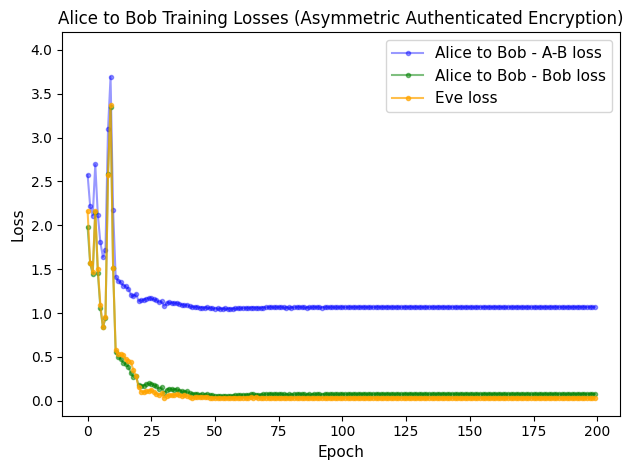

In [ ]:
# Plotting the results
plt.plot(7, 4)
plt.plot(alice_to_bob_abelosses, '.-', color='blue', label='Alice to Bob - A-B loss', alpha=0.4)
plt.plot(alice_to_bob_boblosses, '.-', color='green', label='Alice to Bob - Bob loss', alpha=0.5)
plt.plot(evelosses, '.-', color='orange', label='Eve loss', alpha=0.7)
plt.xlabel("Epoch", fontsize=11)
plt.ylabel("Loss", fontsize=11)
plt.legend(fontsize=11)
plt.title('Alice to Bob Training Losses (Asymmetric Authenticated Encryption)')


plt.tight_layout()
plt.show()


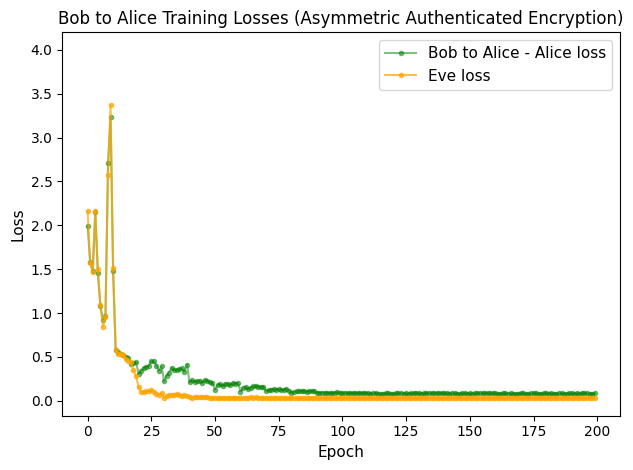

In [ ]:
# plt.plot(bob_to_alice_abelosses, '.-', color='blue', label='Bob to Alice - A-B loss', alpha=0.4)
plt.plot(7, 4)
plt.plot(bob_to_alice_alicelosses, '.-', color='green', label='Bob to Alice - Alice loss', alpha=0.5)
plt.plot(evelosses, '.-', color='orange', label='Eve loss', alpha=0.7)
plt.xlabel("Epoch", fontsize=11)
plt.ylabel("Loss", fontsize=11)
plt.legend(fontsize=11)
plt.title('Bob to Alice Training Losses (Asymmetric Authenticated Encryption)')

plt.tight_layout()

Asymmetric Version 0 updated (Alice and Bob) improved


To make Alice to Bob and Bob to Alice communications better while making Eve worse, we can focus on enhancing the adversarial training mechanism. One effective strategy is to apply more sophisticated regularization techniques and incorporate more robust loss functions that penalize Eve more heavily. Here’s a plan to achieve this:
Enhancements to the Adversarial Training

## Regularization for Alice and Bob:
- Add regularization techniques like dropout or weight decay to the models of Alice and Bob to prevent overfitting.

## Penalty Term for Eve:
- Incorporate a stronger penalty term in Eve's loss function to ensure she does not learn too effectively.

## Loss Function Adjustments:
- Modify the loss functions for Alice and Bob to be more robust, ensuring better encryption and decryption performance.

## Dynamic Learning Rates:
- Adjust learning rates dynamically to ensure that Alice and Bob improve while making it harder for Eve.

# Modifying the Implementation
- Step 1: Regularization in Alice and Bob Models (Adding Dropout Layers to Alice and Bob)

- Step 2: Alice Eve got better in the first experiment so we introduced a penalty term for Eve

In [ ]:
class AsymmetricEncoderModel(nn.Module):
    def __init__(self, m_bits, k_bits, pad='same'):
        super().__init__()
        self.m_bits = m_bits
        self.k_bits = k_bits

        # Encryption part
        self.dense0 = nn.Linear(in_features=m_bits + k_bits, out_features=m_bits + k_bits)
        self.activ0 = nn.Tanh()
        self.dropout = nn.Dropout(0.5)  # Added dropout layer

        self.attn = nn.MultiheadAttention(embed_dim=m_bits + k_bits, num_heads=4)
        self.norm1 = nn.LayerNorm(m_bits + k_bits)

        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=4, stride=1, padding=pad),
            nn.BatchNorm1d(2),
            nn.Tanh(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride=2),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=pad),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride=1, padding=pad),
            nn.Sigmoid()
        )

        # MAC part
        self.mac_dense = nn.Linear(in_features=m_bits, out_features=m_bits // 2)
        self.mac_out = nn.Linear(in_features=m_bits // 2, out_features=m_bits)

    def forward(self, inputs, pub_key):
        m, priv_key = inputs
        pub_key_expanded = pub_key.unsqueeze(0).expand(m.size(0), -1)  # Expand public key to match batch size
        x = torch.cat([m, pub_key_expanded], dim=-1)  # Use the public key for encryption
        x = self.activ0(self.dense0(x))
        x = self.dropout(x)  # Apply dropout

        x = x.unsqueeze(0)  # Add batch dimension
        x, _ = self.attn(x, x, x)
        x = self.norm1(x)
        x = x.squeeze(0)  # Remove batch dimension

        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.squeeze(x, dim=1)

        # Generate MAC
        mac = self.activ0(self.mac_dense(m))
        mac = self.mac_out(mac)

        return x, mac


# Asymmetric Version 0 updated (Train loop)

In [ ]:
def train_single_epoch_two_way(alice, bob, eve, abeoptim, eveoptim, abecycles, evecycles, batch_size=32, device='cuda'):
    n_iterations = 2**16 // batch_size
    iteration = 0
    alice_to_bob_abeloss_sum = 0
    bob_to_alice_abeloss_sum = 0
    alice_to_bob_bobloss_sum = 0
    bob_to_alice_aliceloss_sum = 0
    eveloss_sum = 0

    while iteration < n_iterations:
        alice.train()
        bob.train()
        eve.train()
        for param in alice.parameters():
            param.requires_grad = True
        for param in bob.parameters():
            param.requires_grad = True
        for param in eve.parameters():
            param.requires_grad = False

        # Phase 1: Alice to Bob
        for _ in range(abecycles):
            m_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(device)

            # Alice encrypts with Bob's public key
            ciphertext, mac = alice((m_batch, alice_keys.private_key), bob_keys.public_key)
            # Bob decrypts with his private key and verifies MAC
            bobout, mac_valid = bob((ciphertext, mac, m_batch), bob_keys.private_key, alice_keys.public_key)
            # Eve tries to decrypt the ciphertext
            eveout = eve(ciphertext)

            bobloss = torch.mean(torch.sum(torch.abs(m_batch - bobout), axis=-1))
            alice_to_bob_bobloss_sum += bobloss.cpu().detach().numpy() / abecycles

            eveloss = torch.mean(torch.sum(torch.abs(m_batch - eveout), axis=-1))
            penalty_term = torch.mean(torch.sum(torch.abs(m_batch - eveout)**2, axis=-1))  # Stronger penalty
            abeloss = bobloss + penalty_term
            alice_to_bob_abeloss_sum += abeloss.cpu().detach().numpy() / abecycles

            abeoptim.zero_grad()
            abeloss.backward()
            abeoptim.step()

        # Phase 2: Bob to Alice
        for _ in range(abecycles):
            m_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(device)

            # Bob encrypts with Alice's public key
            ciphertext, mac = alice((m_batch, bob_keys.private_key), alice_keys.public_key)
            # Alice decrypts with her private key and verifies MAC
            aliceout, mac_valid = bob((ciphertext, mac, m_batch), alice_keys.private_key, bob_keys.public_key)
            # Eve tries to decrypt the ciphertext
            eveout = eve(ciphertext)

            aliceloss = torch.mean(torch.sum(torch.abs(m_batch - aliceout), axis=-1))
            bob_to_alice_aliceloss_sum += aliceloss.cpu().detach().numpy() / abecycles

            eveloss = torch.mean(torch.sum(torch.abs(m_batch - eveout), axis=-1))
            penalty_term = torch.mean(torch.sum(torch.abs(m_batch - eveout)**2, axis=-1))  # Stronger penalty
            abeloss = aliceloss + penalty_term
            bob_to_alice_abeloss_sum += abeloss.cpu().detach().numpy() / abecycles

            abeoptim.zero_grad()
            abeloss.backward()
            abeoptim.step()

        # Train Eve for both phases
        for param in alice.parameters():
            param.requires_grad = False
        for param in bob.parameters():
            param.requires_grad = False
        for param in eve.parameters():
            param.requires_grad = True

        for _ in range(evecycles):
            m_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(device)

            ciphertext = alice((m_batch, alice_keys.private_key), bob_keys.public_key)[0]
            eveout = eve(ciphertext)

            eveloss = torch.mean(torch.sum(torch.abs(m_batch - eveout), axis=-1))
            eveloss_sum += eveloss.cpu().detach().numpy() / evecycles

            eveoptim.zero_grad()
            eveloss.backward()
            eveoptim.step()

        iteration += 1

    alice.eval()
    bob.eval()
    eve.eval()
    with torch.no_grad():
        pass

    return (alice_to_bob_abeloss_sum/n_iterations, alice_to_bob_bobloss_sum/n_iterations,
            bob_to_alice_abeloss_sum/n_iterations, bob_to_alice_aliceloss_sum/n_iterations,
            eveloss_sum/n_iterations)

# Initialize models
m_bits = 16
k_bits = 16
c_bits = 16
pad = 'same'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

alice = AsymmetricEncoderModel(m_bits=m_bits, k_bits=k_bits, pad=pad).to(device)
bob = AsymmetricDecoderModel(c_bits=c_bits, k_bits=k_bits, pad=pad).to(device)
eve = AsymmetricAdversaryModel(c_bits=c_bits, pad=pad).to(device)

# Optimizers and Learning Rate Schedulers
abeoptim = optim.Adam(
    params=[
        {'params': alice.parameters(), 'lr': 0.008},
        {'params': bob.parameters(), 'lr': 0.008}
    ], lr=0.008
)
eveoptim = optim.Adam(params=eve.parameters(), lr=0.008)

# abe_scheduler = optim.lr_scheduler.StepLR(abeoptim, step_size=10, gamma=0.5)
# eve_scheduler = optim.lr_scheduler.StepLR(eveoptim, step_size=10, gamma=0.5)

alice_to_bob_abelosses = []
alice_to_bob_boblosses = []
bob_to_alice_abelosses = []
bob_to_alice_alicelosses = []
evelosses = []

n_epochs = 200
abecycles = 1
evecycles = 2

print(f'Training for {n_epochs} epochs with asymmetric encryption')

for epoch in range(n_epochs):
    (alice_to_bob_abeloss, alice_to_bob_bobloss,
     bob_to_alice_abeloss, bob_to_alice_aliceloss,
     eveloss) = train_single_epoch_two_way(
        alice=alice, bob=bob, eve=eve, abeoptim=abeoptim, eveoptim=eveoptim,
        abecycles=abecycles, evecycles=evecycles, batch_size=256, device=device
    )
    alice_to_bob_abelosses.append(alice_to_bob_abeloss)
    alice_to_bob_boblosses.append(alice_to_bob_bobloss)
    bob_to_alice_abelosses.append(bob_to_alice_abeloss)
    bob_to_alice_alicelosses.append(bob_to_alice_aliceloss)
    evelosses.append(eveloss)

    abe_scheduler.step()
    eve_scheduler.step()

    print(f'Epoch {epoch:3d}: alice_to_bob_abe={alice_to_bob_abeloss:.3f} | alice_to_bob_bob={alice_to_bob_bobloss:.3f} | bob_to_alice_abe={bob_to_alice_abeloss:.3f} | bob_to_alice_alice={bob_to_alice_aliceloss:.3f} | eve={eveloss:.3f}')



Training for 200 epochs with asymmetric encryption
Epoch   0: alice_to_bob_abe=8.297 | alice_to_bob_bob=4.522 | bob_to_alice_abe=8.318 | bob_to_alice_alice=4.532 | eve=4.379
Epoch   1: alice_to_bob_abe=7.505 | alice_to_bob_bob=3.811 | bob_to_alice_abe=7.554 | bob_to_alice_alice=3.840 | eve=3.770
Epoch   2: alice_to_bob_abe=7.564 | alice_to_bob_bob=3.819 | bob_to_alice_abe=7.582 | bob_to_alice_alice=3.837 | eve=3.776
Epoch   3: alice_to_bob_abe=7.651 | alice_to_bob_bob=3.867 | bob_to_alice_abe=7.686 | bob_to_alice_alice=3.889 | eve=3.815
Epoch   4: alice_to_bob_abe=7.643 | alice_to_bob_bob=3.840 | bob_to_alice_abe=7.702 | bob_to_alice_alice=3.871 | eve=3.826
Epoch   5: alice_to_bob_abe=7.766 | alice_to_bob_bob=3.905 | bob_to_alice_abe=7.820 | bob_to_alice_alice=3.937 | eve=3.877
Epoch   6: alice_to_bob_abe=7.735 | alice_to_bob_bob=3.886 | bob_to_alice_abe=7.788 | bob_to_alice_alice=3.910 | eve=3.869
Epoch   7: alice_to_bob_abe=7.869 | alice_to_bob_bob=3.961 | bob_to_alice_abe=7.912 | bo

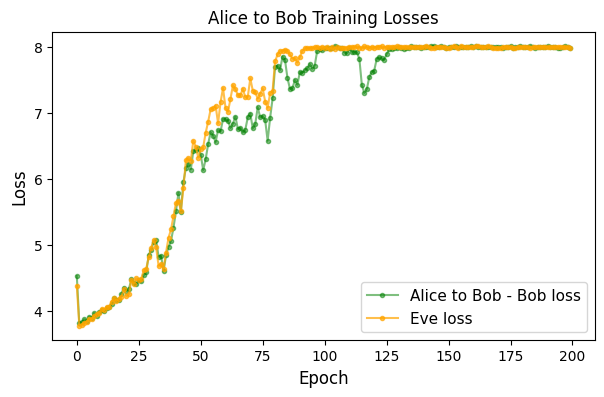

In [ ]:
# Plotting the results
plt.figure(figsize=(7, 4))
# plt.plot(alice_to_bob_abelosses, '.-', color='blue', label='Alice to Bob - A-B loss', alpha=0.4)
plt.plot(alice_to_bob_boblosses, '.-', color='green', label='Alice to Bob - Bob loss', alpha=0.5)
plt.plot(evelosses, '.-', color='orange', label='Eve loss', alpha=0.7)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=11)
plt.title('Alice to Bob Training Losses')

# plt.tight_layout()
plt.show()


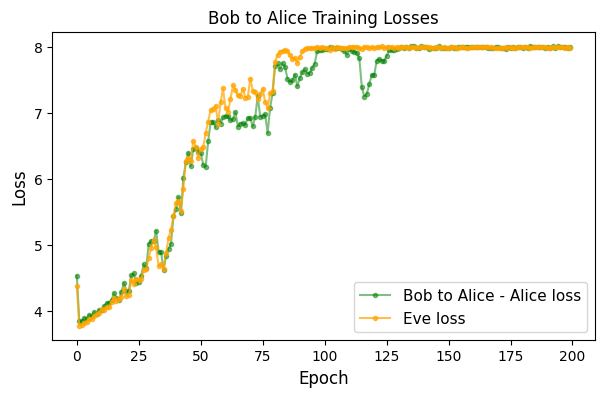

In [ ]:
plt.figure(figsize=(7, 4))
# plt.plot(bob_to_alice_abelosses, '.-', color='blue', label='Bob to Alice - A-B loss', alpha=0.4)
plt.plot(bob_to_alice_alicelosses, '.-', color='green', label='Bob to Alice - Alice loss', alpha=0.5)
plt.plot(evelosses, '.-', color='orange', label='Eve loss', alpha=0.7)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=11)
plt.title('Bob to Alice Training Losses')

# plt.tight_layout()
plt.show()

# Asymmetric Version 1

# Asymmetric Version 2 (Eve keeps getting better)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# KeyPair class definition and key generation remain the same
class KeyPair:
    def __init__(self, key_size):
        self.public_key = torch.rand(key_size)  # Placeholder for public key
        self.private_key = torch.rand(key_size)  # Placeholder for private key

# Generate key pairs for Alice and Bob
alice_keys = KeyPair(key_size=16)
bob_keys = KeyPair(key_size=16)

# Define the models with regularization (dropout)
class AsymmetricEncoderModel(nn.Module):
    def __init__(self, m_bits, k_bits, pad='same'):
        super().__init__()
        self.m_bits = m_bits
        self.k_bits = k_bits

        # Encryption part
        self.dense0 = nn.Linear(in_features=m_bits + k_bits, out_features=m_bits + k_bits)
        self.activ0 = nn.Tanh()
        self.dropout = nn.Dropout(0.5)  # Added dropout layer

        self.attn = nn.MultiheadAttention(embed_dim=m_bits + k_bits, num_heads=4)
        self.norm1 = nn.LayerNorm(m_bits + k_bits)

        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=4, stride=1, padding=pad),
            nn.BatchNorm1d(2),
            nn.Tanh(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride=2),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=pad),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride=1, padding=pad),
            nn.Sigmoid()
        )

        # MAC part
        self.mac_dense = nn.Linear(in_features=m_bits, out_features=m_bits // 2)
        self.mac_out = nn.Linear(in_features=m_bits // 2, out_features=m_bits)

    def forward(self, inputs, pub_key):
        m, priv_key = inputs
        pub_key_expanded = pub_key.unsqueeze(0).expand(m.size(0), -1)  # Expand public key to match batch size
        x = torch.cat([m, pub_key_expanded], dim=-1)  # Use the public key for encryption
        x = self.activ0(self.dense0(x))
        x = self.dropout(x)  # Apply dropout

        x = x.unsqueeze(0)  # Add batch dimension
        x, _ = self.attn(x, x, x)
        x = self.norm1(x)
        x = x.squeeze(0)  # Remove batch dimension

        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.squeeze(x, dim=1)

        # Generate MAC
        mac = self.activ0(self.mac_dense(m))
        mac = self.mac_out(mac)

        return x, mac

class AsymmetricDecoderModel(nn.Module):
    def __init__(self, c_bits, k_bits, pad='same'):
        super().__init__()
        self.c_bits = c_bits
        self.k_bits = k_bits

        self.dense0 = nn.Linear(in_features=c_bits + k_bits, out_features=c_bits + k_bits)
        self.activ0 = nn.Tanh()
        self.dropout = nn.Dropout(0.5)  # Added dropout layer

        self.attn = nn.MultiheadAttention(embed_dim=c_bits + k_bits, num_heads=4)
        self.norm1 = nn.LayerNorm(c_bits + k_bits)

        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=4, stride=1, padding=pad),
            nn.BatchNorm1d(2),
            nn.Tanh(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride=2),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=pad),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride=1, padding=pad),
            nn.Sigmoid()
        )

        # MAC verification part
        self.mac_dense = nn.Linear(in_features=c_bits, out_features=c_bits // 2)
        self.mac_out = nn.Linear(in_features=c_bits // 2, out_features=c_bits)

    def forward(self, inputs, priv_key, pub_key):
        c, mac_received, m_true = inputs
        priv_key_expanded = priv_key.unsqueeze(0).expand(c.size(0), -1)  # Expand private key to match batch size
        x = torch.cat([c, priv_key_expanded], dim=-1)  # Use the private key for decryption
        x = self.activ0(self.dense0(x))
        x = self.dropout(x)  # Apply dropout

        x = x.unsqueeze(0)  # Add batch dimension
        x, _ = self.attn(x, x, x)
        x = self.norm1(x)
        x = x.squeeze(0)  # Remove batch dimension

        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.squeeze(x, dim=1)

        # Verify MAC
        mac = self.activ0(self.mac_dense(x))
        mac = self.mac_out(mac)

        mac_valid = torch.allclose(mac, mac_received)

        return x, mac_valid

class AsymmetricAdversaryModel(nn.Module):
    def __init__(self, c_bits, pad='same'):
        super().__init__()
        self.c_bits = c_bits

        self.dense0 = nn.Linear(in_features=c_bits, out_features=c_bits + c_bits)
        self.activ0 = nn.Tanh()
        self.dense1 = nn.Linear(in_features=c_bits + c_bits, out_features=c_bits + c_bits)
        self.activ1 = nn.Tanh()

        self.attn = nn.MultiheadAttention(embed_dim=c_bits + c_bits, num_heads=4)
        self.norm1 = nn.LayerNorm(c_bits + c_bits)

        self.convops = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=4, stride=1, padding=pad),
            nn.BatchNorm1d(2),
            nn.Tanh(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride=2),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=pad),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride=1, padding=pad),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        c = inputs
        x = self.activ0(self.dense0(c))
        x = self.activ1(self.dense1(x))

        x = x.unsqueeze(0)  # Add batch dimension
        x, _ = self.attn(x, x, x)
        x = self.norm1(x)
        x = x.squeeze(0)  # Remove batch dimension

        x = torch.unsqueeze(x, dim=1)
        x = self.convops(x)
        x = torch.squeeze(x, dim=1)

        return x

def train_single_epoch_two_way(alice, bob, eve, abeoptim, eveoptim, abecycles, evecycles, batch_size=32, device='cuda'):
    n_iterations = 2**16 // batch_size
    iteration = 0
    alice_to_bob_abeloss_sum = 0
    bob_to_alice_abeloss_sum = 0
    alice_to_bob_bobloss_sum = 0
    bob_to_alice_aliceloss_sum = 0
    eveloss_sum = 0
    eve_bobloss_sum = 0
    eve_aliceloss_sum = 0

    while iteration < n_iterations:
        alice.train()
        bob.train()
        eve.train()
        for param in alice.parameters():
            param.requires_grad = True
        for param in bob.parameters():
            param.requires_grad = True
        for param in eve.parameters():
            param.requires_grad = False

        # Phase 1: Alice to Bob
        for _ in range(abecycles):
            m_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(device)

            # Alice encrypts with Bob's public key
            ciphertext, mac = alice((m_batch, alice_keys.private_key), bob_keys.public_key)
            # Bob decrypts with his private key and verifies MAC
            bobout, mac_valid = bob((ciphertext, mac, m_batch), bob_keys.private_key, alice_keys.public_key)
            # Eve tries to decrypt the ciphertext
            eveout = eve(ciphertext)

            bobloss = torch.mean(torch.sum(torch.abs(m_batch - bobout), axis=-1))
            alice_to_bob_bobloss_sum += bobloss.cpu().detach().numpy() / abecycles

            eveloss = torch.mean(torch.sum(torch.abs(m_batch - eveout), axis=-1))
            penalty_term = torch.mean(torch.sum(torch.abs(m_batch - eveout)**2, axis=-1))  # Stronger penalty
            abeloss = bobloss + penalty_term
            alice_to_bob_abeloss_sum += abeloss.cpu().detach().numpy() / abecycles
            eve_bobloss_sum += eveloss.cpu().detach().numpy() / abecycles

            abeoptim.zero_grad()
            abeloss.backward()
            abeoptim.step()

        # Phase 2: Bob to Alice
        for _ in range(abecycles):
            m_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(device)

            # Bob encrypts with Alice's public key
            ciphertext, mac = alice((m_batch, bob_keys.private_key), alice_keys.public_key)
            # Alice decrypts with her private key and verifies MAC
            aliceout, mac_valid = bob((ciphertext, mac, m_batch), alice_keys.private_key, bob_keys.public_key)
            # Eve tries to decrypt the ciphertext
            eveout = eve(ciphertext)

            aliceloss = torch.mean(torch.sum(torch.abs(m_batch - aliceout), axis=-1))
            bob_to_alice_aliceloss_sum += aliceloss.cpu().detach().numpy() / abecycles

            eveloss = torch.mean(torch.sum(torch.abs(m_batch - eveout), axis=-1))
            penalty_term = torch.mean(torch.sum(torch.abs(m_batch - eveout)**2, axis=-1))  # Stronger penalty
            abeloss = aliceloss + penalty_term
            bob_to_alice_abeloss_sum += abeloss.cpu().detach().numpy() / abecycles
            eve_aliceloss_sum += eveloss.cpu().detach().numpy() / abecycles

            abeoptim.zero_grad()
            abeloss.backward()
            abeoptim.step()

        # Train Eve for both phases
        for param in alice.parameters():
            param.requires_grad = False
        for param in bob.parameters():
            param.requires_grad = False
        for param in eve.parameters():
            param.requires_grad = True

        for _ in range(evecycles):
            m_batch = torch.Tensor(np.random.randint(0, 2, 16 * batch_size).reshape(batch_size, 16)).to(device)

            ciphertext = alice((m_batch, alice_keys.private_key), bob_keys.public_key)[0]
            eveout = eve(ciphertext)

            eveloss = torch.mean(torch.sum(torch.abs(m_batch - eveout), axis=-1))
            eveloss_sum += eveloss.cpu().detach().numpy() / evecycles

            eveoptim.zero_grad()
            eveloss.backward()
            eveoptim.step()

        iteration += 1

    alice.eval()
    bob.eval()
    eve.eval()
    with torch.no_grad():
        pass

    return (alice_to_bob_abeloss_sum/n_iterations, alice_to_bob_bobloss_sum/n_iterations,
            bob_to_alice_abeloss_sum/n_iterations, bob_to_alice_aliceloss_sum/n_iterations,
            eveloss_sum/n_iterations, eve_bobloss_sum/n_iterations, eve_aliceloss_sum/n_iterations)

# Initialize models
m_bits = 16
k_bits = 16
c_bits = 16
pad = 'same'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

alice = AsymmetricEncoderModel(m_bits=m_bits, k_bits=k_bits, pad=pad).to(device)
bob = AsymmetricDecoderModel(c_bits=c_bits, k_bits=k_bits, pad=pad).to(device)
eve = AsymmetricAdversaryModel(c_bits=c_bits, pad=pad).to(device)

# Optimizers and Learning Rate Schedulers
abeoptim = optim.Adam(
    params=[
        {'params': alice.parameters(), 'lr': 0.008},
        {'params': bob.parameters(), 'lr': 0.008}
    ], lr=0.008
)
eveoptim = optim.Adam(params=eve.parameters(), lr=0.008)

# abe_scheduler = optim.lr_scheduler.StepLR(abeoptim, step_size=10, gamma=0.5)
# eve_scheduler = optim.lr_scheduler.StepLR(eveoptim, step_size=10, gamma=0.5)

alice_to_bob_abelosses = []
alice_to_bob_boblosses = []
bob_to_alice_abelosses = []
bob_to_alice_alicelosses = []
evelosses = []
eve_boblosses = []
eve_alicelosses = []

n_epochs = 200
abecycles = 1
evecycles = 2

print(f'Training for {n_epochs} epochs with asymmetric encryption')



Training for 200 epochs with asymmetric encryption


In [ ]:
for epoch in range(n_epochs):
    (alice_to_bob_abeloss, alice_to_bob_bobloss,
     bob_to_alice_abeloss, bob_to_alice_aliceloss,
     eveloss, eve_bobloss, eve_aliceloss) = train_single_epoch_two_way(
        alice=alice, bob=bob, eve=eve, abeoptim=abeoptim, eveoptim=eveoptim,
        abecycles=abecycles, evecycles=evecycles, batch_size=256, device=device
    )
    alice_to_bob_abelosses.append(alice_to_bob_abeloss)
    alice_to_bob_boblosses.append(alice_to_bob_bobloss)
    bob_to_alice_abelosses.append(bob_to_alice_abeloss)
    bob_to_alice_alicelosses.append(bob_to_alice_aliceloss)
    evelosses.append(eveloss)
    eve_boblosses.append(eve_bobloss)
    eve_alicelosses.append(eve_aliceloss)

    # abe_scheduler.step()
    # eve_scheduler.step()

    print(f'Epoch {epoch:3d}: alice_to_bob_abe={alice_to_bob_abeloss:.3f} | alice_to_bob_bob={alice_to_bob_bobloss:.3f} | bob_to_alice_abe={bob_to_alice_abeloss:.3f} | bob_to_alice_alice={bob_to_alice_aliceloss:.3f} | eve={eveloss:.3f}')



Epoch   0: alice_to_bob_abe=9.178 | alice_to_bob_bob=5.093 | bob_to_alice_abe=9.182 | bob_to_alice_alice=5.072 | eve=4.682
Epoch   1: alice_to_bob_abe=8.570 | alice_to_bob_bob=4.607 | bob_to_alice_abe=8.580 | bob_to_alice_alice=4.591 | eve=4.038
Epoch   2: alice_to_bob_abe=8.133 | alice_to_bob_bob=4.377 | bob_to_alice_abe=8.178 | bob_to_alice_alice=4.389 | eve=3.812
Epoch   3: alice_to_bob_abe=8.013 | alice_to_bob_bob=4.264 | bob_to_alice_abe=8.080 | bob_to_alice_alice=4.288 | eve=3.780
Epoch   4: alice_to_bob_abe=7.980 | alice_to_bob_bob=4.241 | bob_to_alice_abe=8.013 | bob_to_alice_alice=4.243 | eve=3.764
Epoch   5: alice_to_bob_abe=7.987 | alice_to_bob_bob=4.233 | bob_to_alice_abe=8.034 | bob_to_alice_alice=4.250 | eve=3.768
Epoch   6: alice_to_bob_abe=8.030 | alice_to_bob_bob=4.249 | bob_to_alice_abe=8.112 | bob_to_alice_alice=4.290 | eve=3.791
Epoch   7: alice_to_bob_abe=8.091 | alice_to_bob_bob=4.294 | bob_to_alice_abe=8.141 | bob_to_alice_alice=4.302 | eve=3.798
Epoch   8: alice

Text(0.5, 1.0, 'Alice to Bob Training Losses')

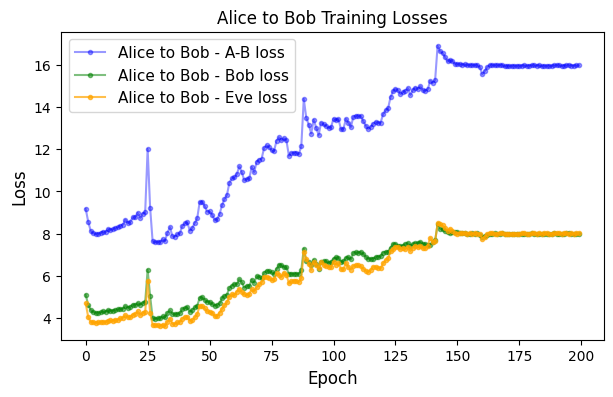

In [ ]:
# Plotting the results
plt.figure(figsize=(7, 4))

plt.plot(alice_to_bob_abelosses, '.-', color='blue', label='Alice to Bob - A-B loss', alpha=0.4)
plt.plot(alice_to_bob_boblosses, '.-', color='green', label='Alice to Bob - Bob loss', alpha=0.5)
plt.plot(eve_boblosses, '.-', color='orange', label='Alice to Bob - Eve loss', alpha=0.7)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=11)
plt.title('Alice to Bob Training Losses')




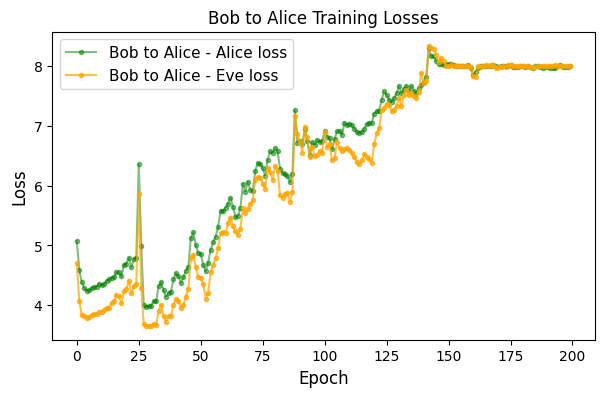

In [ ]:
plt.figure(figsize=(7, 4))

# plt.plot(bob_to_alice_abelosses, '.-', color='blue', label='Bob to Alice - A-B loss', alpha=0.4)
plt.plot(bob_to_alice_alicelosses, '.-', color='green', label='Bob to Alice - Alice loss', alpha=0.5)
plt.plot(eve_alicelosses, '.-', color='orange', label='Bob to Alice - Eve loss', alpha=0.7)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=11)
plt.title('Bob to Alice Training Losses')

# plt.tight_layout()
plt.show()